# Reducción de la dimensión (lineal)

_Santander Meteorology Group (08-01-2025)_

 * [Introducción](#Introducción)
 * [Paquetes utilizados](#Paquetes-utilizados)
 * [Base de datos de ejemplo: Breast cancer](#Base-de-datos:-Breast-cancer)
 * [Tareas propuestas](#Tareas-propuestas)

## Introducción

En esta práctica analizaremos una base de datos de cáncer de mama (breastcancer.csv, disponible en Moodle), que contiene características de los núcleos celulares extraídas de imágenes de biopsias. En esta práctica trataremos de aplicar técnicas proyectivas lineales de reducción de la dimensión: PCA y LDA.

El objetivo principal de un modelo entrenado es que tenga la capacidad de generalizar, es decir, la capacidad de predecir bien nuevos datos que no formen parte de la muestra de entrenamiento (por ejemplo, una muestra de datos de *test*). La relación entre el número de observaciones y el número de variables independientes es clave en la capacidad de generalización de los modelos.

## Paquetes utilizados

In [15]:
library(MASS) # lda
library(caret) # confusionMatrix
library(pROC) # auc
#library(verification) # roc.area, roc.plot (opcional)
#library(RColorBrewer) # brewer.pal (opcional)
#library(lattice) # levelplot (opcional)

## Base de datos: Breast cancer

En este ejemplo trabajaremos con la base de datos [_Breast cancer_ (Diagnostic)](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data), incluida en Kaggle. Consulta el enlace para conocer el dataset y, concretamente, las variables predictoras. El objetivo de este conjunto de datos es clasificar a las pacientes en base a si el cáncer de mama que tienen es benigno (`B`) o maligno (`M`). Para ello se utilizan 30 predictores relacionados con las propiedades de las células cancerígenas, que en comparación con el número de observaciones (569) es bajo.

Leemos la base de datos:

In [16]:
datos <- read.csv("breastcancer.csv")
str(datos)

'data.frame':	569 obs. of  33 variables:
 $ id                     : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : chr  "M" "M" "M" "M" ...
 $ radius_mean            : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave.points_mean    : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num  0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num  1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se             : num  0.905 0.734 0.787 1

Y preparamos la base de datos de la siguiente manera:

In [17]:
# Eliminar variables no predictoras (id y última columna vacía)
df <- datos[, -c(1, ncol(datos))]
# Convertir diagnosis (B y M) a los valores 0 y 1, respectivamente, y convertirlo a factor.
df$diagnosis <- as.factor(ifelse(df$diagnosis=="M", "1", "0"))
# Normalizar los datos (predictores o features) para evitar problemas de diferente variabilidad
df[-1] <- apply(df[-1], MARGIN = 2, scale) # scale centra y estandariza por defecto
rm(datos)
dim(df)
head(df)

[1] 569  31

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,⋯,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.0960995,-2.0715123,1.2688173,0.9835095,1.5670875,3.2806281,2.65054179,2.5302489,2.215565542,⋯,1.8850310,-1.35809849,2.3015755,1.9994782,1.3065367,2.6143647,2.1076718,2.2940576,2.7482041,1.9353117
2,1,1.8282120,-0.3533215,1.6844726,1.9070303,-0.8262354,-0.4866435,-0.02382489,0.5476623,0.001391139,⋯,1.8043398,-0.36887865,1.5337764,1.8888270,-0.3752817,-0.4300658,-0.1466200,1.0861286,-0.2436753,0.2809428
3,1,1.5784992,0.4557859,1.5651260,1.5575132,0.9413821,1.0519999,1.36227979,2.0354398,0.938858720,⋯,1.5105411,-0.02395331,1.3462906,1.4550043,0.5269438,1.0819801,0.8542223,1.9532817,1.1512420,0.2012142
4,1,-0.7682333,0.2535091,-0.5921661,-0.7637917,3.2806668,3.3999174,1.91421287,1.4504311,2.864862154,⋯,-0.2812170,0.13386631,-0.2497196,-0.5495377,3.3912907,3.8899747,1.9878392,2.1738732,6.0407261,4.9306719
5,1,1.7487579,-1.1508038,1.7750113,1.8246238,0.2801253,0.5388663,1.36980615,1.4272370,-0.009552062,⋯,1.2974336,-1.46548091,1.3373627,1.2196511,0.2203623,-0.3131190,0.6126397,0.7286181,-0.8675896,-0.3967505
6,1,-0.4759559,-0.8346009,-0.3868077,-0.5052059,2.2354545,1.2432416,0.86554001,0.8239307,1.004517928,⋯,-0.1653528,-0.31356043,-0.1149083,-0.2441054,2.0467119,1.7201029,1.2621327,0.9050914,1.7525273,2.2398308


Podemos comprobar que hay colinealidades en los datos:

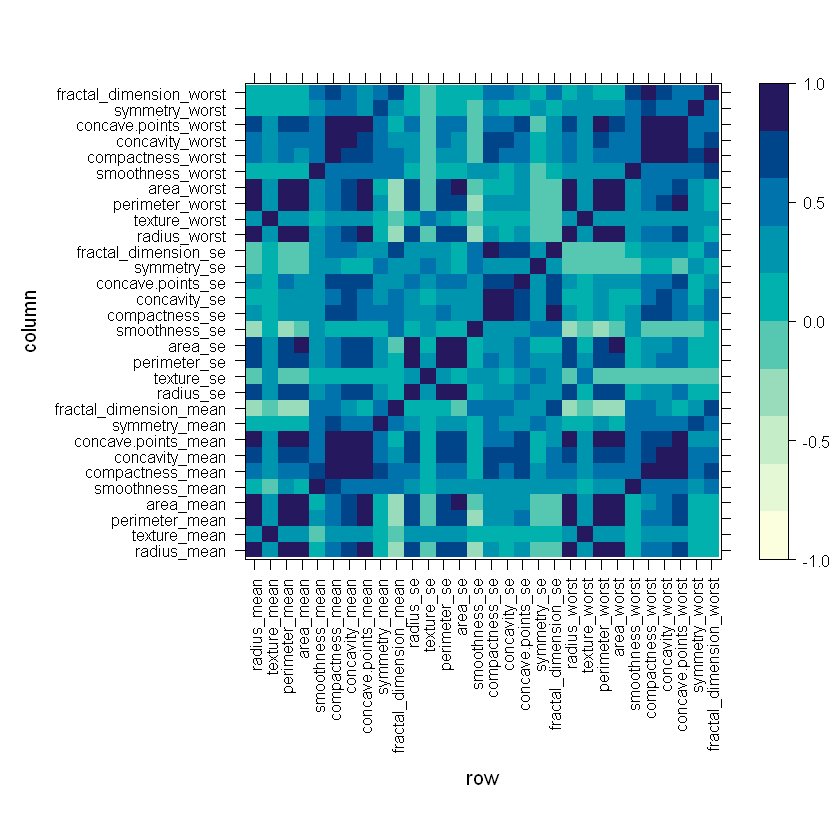

In [18]:
#colores <- brewer.pal(10,"RdBu")
levelplot(cor(df[,-1]), # ó simplemente image(cor(df[,-1]))
  at = seq(-1, 1, 0.2),
  scale = list(x = list(rot = 90)) # gira 90º las etiquetas del eje X
)

## Tareas propuestas
 
 #### 1. Análisis de Componentes Principales
 
  1.1. Realiza un Análisis de Componentes Principales de las covariables de esta base de datos. Estudia el número óptimo de variables a considerar a la vista de un Scree plot (`?screeplot`). Utiliza un gráfico de varianza explicada acumulada para visualizar la fracción de varianza explicada por estas variables.
 
  1.2. Un *biplot* (`?biplot` `?biplot.princomp` del paquete `stats`) permite visualizar tanto las observaciones como las covariables proyectados sobre las dos primeras PCs. Represéntalo para esta base de datos.
 
  1.3. El biplot es útil cuando el número de covariables no es muy elevado. Representa gráficamente las primera EOFs de esta base de datos (p.ej. usando `?barplot`), para poder interpretar mejor las combinaciones lineales de covariables a las que dan lugar. Comprueba también su ortogonalidad.
 
  1.4.  Representa una de las muestras, junto con su reconstrucción mediante las r primeras PCs. Comprueba el efecto de aumentar el valor de r, dando algunos valores de 1 a 30.
  
#### 2. Análisis Discriminante Lineal
 
  2.1. Realiza un Análisis Discriminante Lineal sobre esta base de datos. En este caso, se trata de una técnica de aprendizaje supervisado, en la que involucramos la variable respuesta en la elección de direcciones de proyección de los datos. Representa gráficamente la primera (y única, en este caso, por tener solo dos clases) dirección discriminante (p.ej. usando `?barplot`).
 
  2.2. Utiliza LDA para predecir usando el conjunto de datos completo. Examina los valores de la salida de la función (`?predict`, `?predict.lda`) y representa la distribución de los datos proyectados a lo largo de la dirección dada por el primer LD (p.ej `?plot` o `?ldahist`).
 
  2.3. Obtén una tabla de contingencia para estudiar la pericia de este método lineal de clasificación.
 
  2.4. El LDA proporciona una predicción probabilista de las clases, ya que esta técnica implementa un clasificador bayesiano, basado en las probabilidades a posteriori de pertenencia a cada clase, bajo la hipótesis de normalidad. Utilizar una técnica de validación probabilista, como la curva ROC para evaluar la pericia de esta predicción probabilista.
 
  2.5. Repetir lo anterior pero mediante una validación cruzada tipo *hold out*, para ver la capacidad de generalización de esta técnica lineal.
 
#### 3. (Opcional) Repetir todos los pasos de esta práctica para otra base de datos de tu elección. Para visualizar mejor los resultados es preferible que no tenga demasiadas covariables, como por ejemplo `ISLR::Hitters` o `USArrests` (consulta la ayuda para ver de qué se trata).

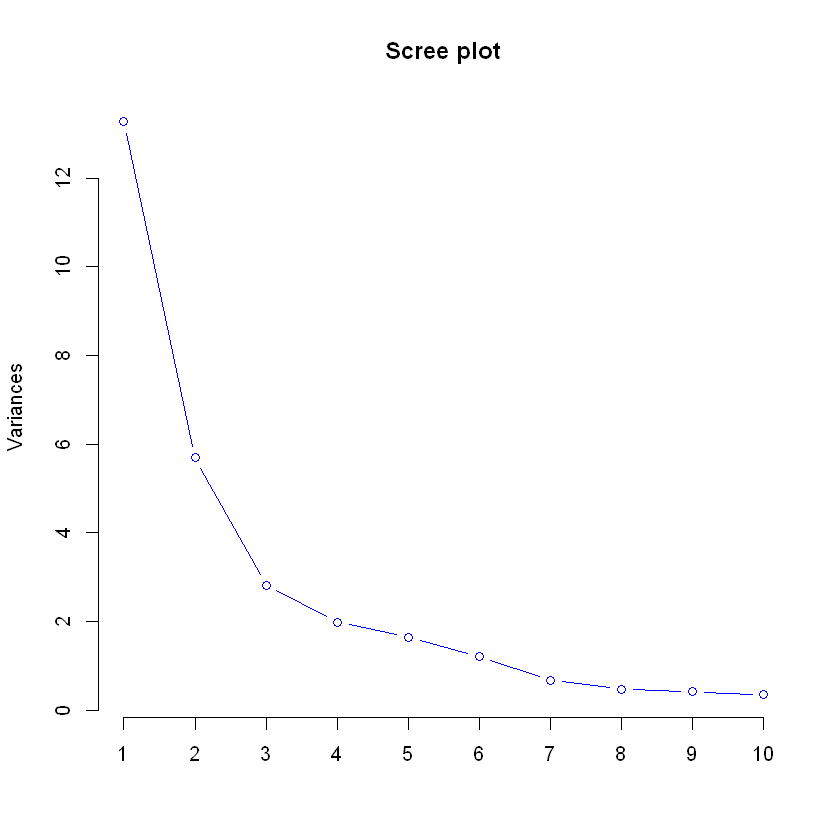

De acuerdo a la grafica se observa que podrian tomarse 10 componentes principales, 
los cuales explican el 95% de la varianza de los datos, lo cual es basntante bueno.
Observamos que despues de esta valor la varianza aumenta muy poco, por lo que no se
justifica tomar mas componentes y podria considerarse como ruido. 

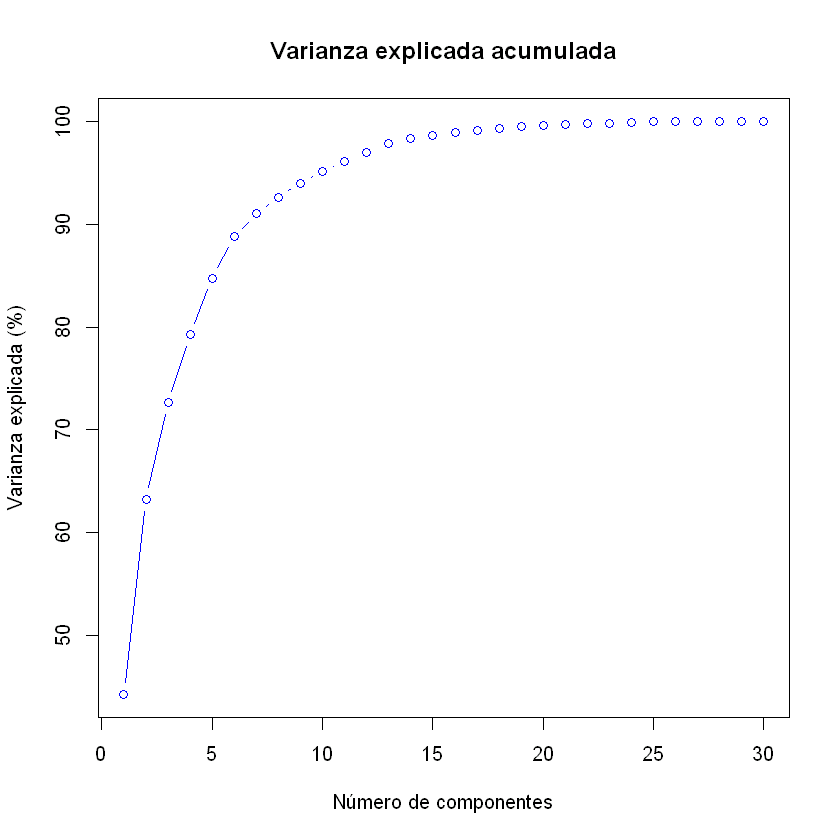

In [19]:
# Realiza un Análisis de Componentes Principales de las covariables de esta base de datos.
# Estudia el número óptimo de variables a considerar a la vista de un Scree plot (`?screeplot`). 
#Utiliza un gráfico de varianza explicada acumulada para visualizar la fracción de varianza
# explicada por estas variables.

pca = prcomp(df[-1], scale = TRUE, center = TRUE)

screeplot(pca, type = "lines", col = "blue", main = "Scree plot")

varianza_acumulada = cumsum(pca$sdev^2) / sum(pca$sdev^2) * 100

plot(varianza_acumulada, type = "b", col = "blue", xlab = "Número de componentes", ylab = "Varianza explicada (%)", main = "Varianza explicada acumulada")

cat("De acuerdo a la grafica se observa que podrian tomarse 10 componentes principales, 
los cuales explican el 95% de la varianza de los datos, lo cual es basntante bueno.
Observamos que despues de esta valor la varianza aumenta muy poco, por lo que no se
justifica tomar mas componentes y podria considerarse como ruido. ")


Este tipo de graficas es mas útil con datasets de pocas dimensiones,
porque muchas variables es dificil de interpretar visualmente.

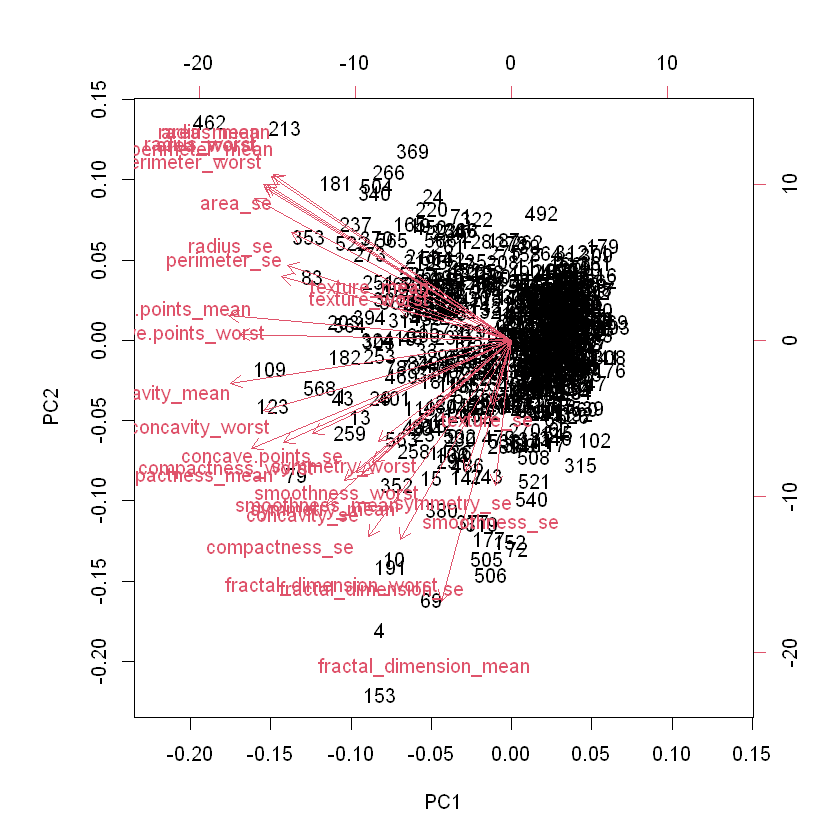

In [20]:
#Un *biplot* (`?biplot` `?biplot.princomp` del paquete `stats`) permite visualizar tanto las observaciones
# como las covariables proyectados sobre las dos primeras PCs. Represéntalo para esta base de datos.

biplot(pca, choice = c(1, 2))

cat("Este tipo de graficas es mas útil con datasets de pocas dimensiones,
porque muchas variables es dificil de interpretar visualmente.")

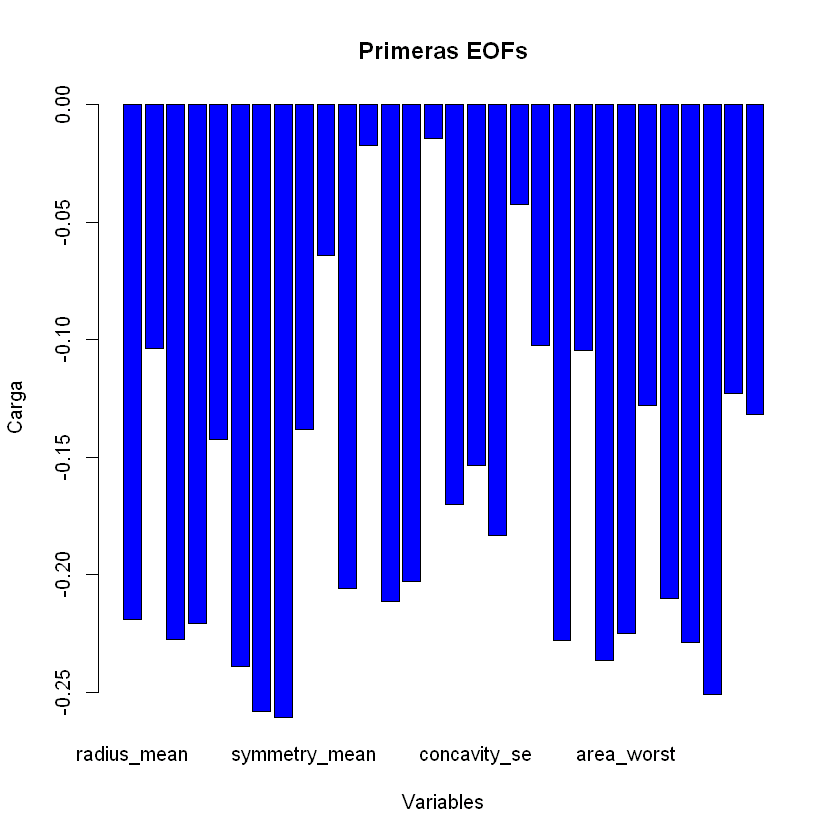

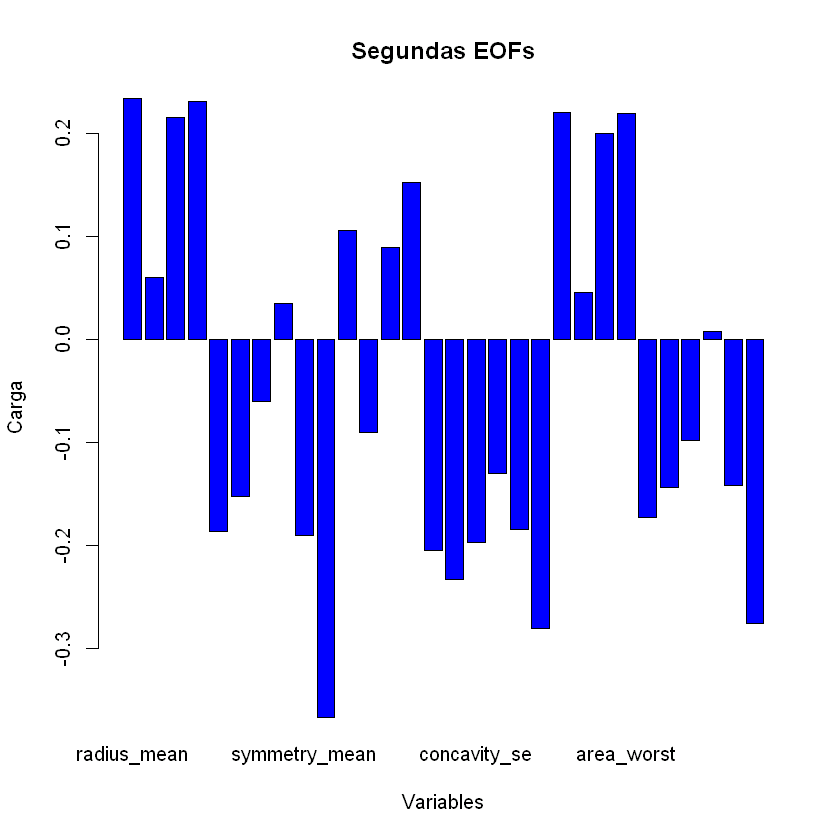

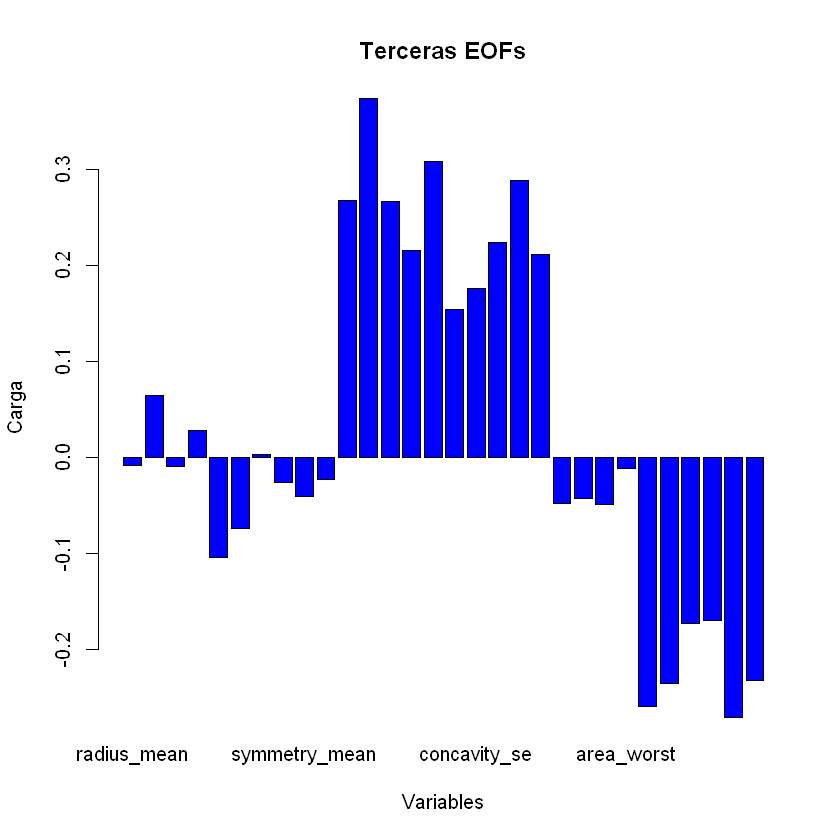

En estas graficas se puede observar cuales son las variables que mas influyen en cada componente principal.
ADemas, se observa como las variables son ortogonales entre si, complementandose para explicar la varianza de los datos.
Por ejemplo, resalta la variable symmetry_mean en la primera eof.

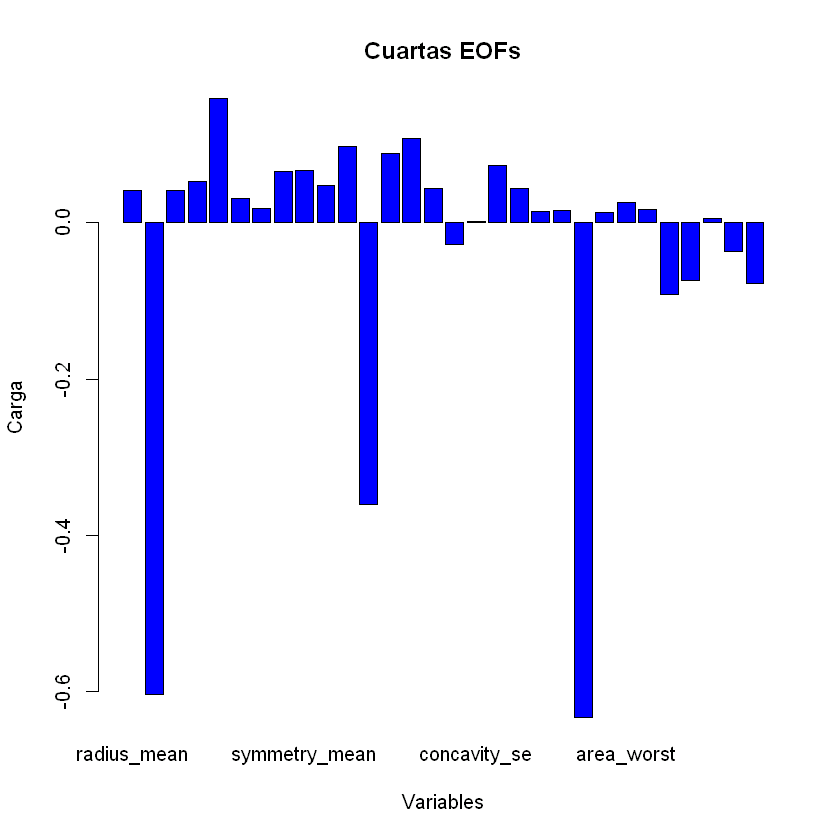

In [21]:
#  3. El biplot es útil cuando el número de covariables no es muy elevado. 
#Representa gráficamente las primera EOFs de esta base de datos (p.ej. usando `?barplot`), 
#para poder interpretar mejor las combinaciones lineales de covariables a las que dan lugar. 
#Comprueba también su ortogonalidad.

# Representación gráfica de las primeras EOFs
barplot(pca$rotation[, 1], col = "blue", main = "Primeras EOFs", xlab = "Variables", ylab = "Carga")

barplot(pca$rotation[, 2], col = "blue", main = "Segundas EOFs", xlab = "Variables", ylab = "Carga")

barplot(pca$rotation[, 3], col = "blue", main = "Terceras EOFs", xlab = "Variables", ylab = "Carga")

barplot(pca$rotation[, 4], col = "blue", main = "Cuartas EOFs", xlab = "Variables", ylab = "Carga")

cat("En estas graficas se puede observar cuales son las variables que mas influyen en cada componente principal.
ADemas, se observa como las variables son ortogonales entre si, complementandose para explicar la varianza de los datos.
Por ejemplo, resalta la variable symmetry_mean en la primera eof.")

In [22]:
str(df)

'data.frame':	569 obs. of  31 variables:
 $ diagnosis              : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ radius_mean            : num  1.096 1.828 1.578 -0.768 1.749 ...
 $ texture_mean           : num  -2.072 -0.353 0.456 0.254 -1.151 ...
 $ perimeter_mean         : num  1.269 1.684 1.565 -0.592 1.775 ...
 $ area_mean              : num  0.984 1.907 1.558 -0.764 1.825 ...
 $ smoothness_mean        : num  1.567 -0.826 0.941 3.281 0.28 ...
 $ compactness_mean       : num  3.281 -0.487 1.052 3.4 0.539 ...
 $ concavity_mean         : num  2.6505 -0.0238 1.3623 1.9142 1.3698 ...
 $ concave.points_mean    : num  2.53 0.548 2.035 1.45 1.427 ...
 $ symmetry_mean          : num  2.21557 0.00139 0.93886 2.86486 -0.00955 ...
 $ fractal_dimension_mean : num  2.254 -0.868 -0.398 4.907 -0.562 ...
 $ radius_se              : num  2.488 0.499 1.228 0.326 1.269 ...
 $ texture_se             : num  -0.565 -0.875 -0.779 -0.11 -0.79 ...
 $ perimeter_se           : num  2.831 0.263 0.85

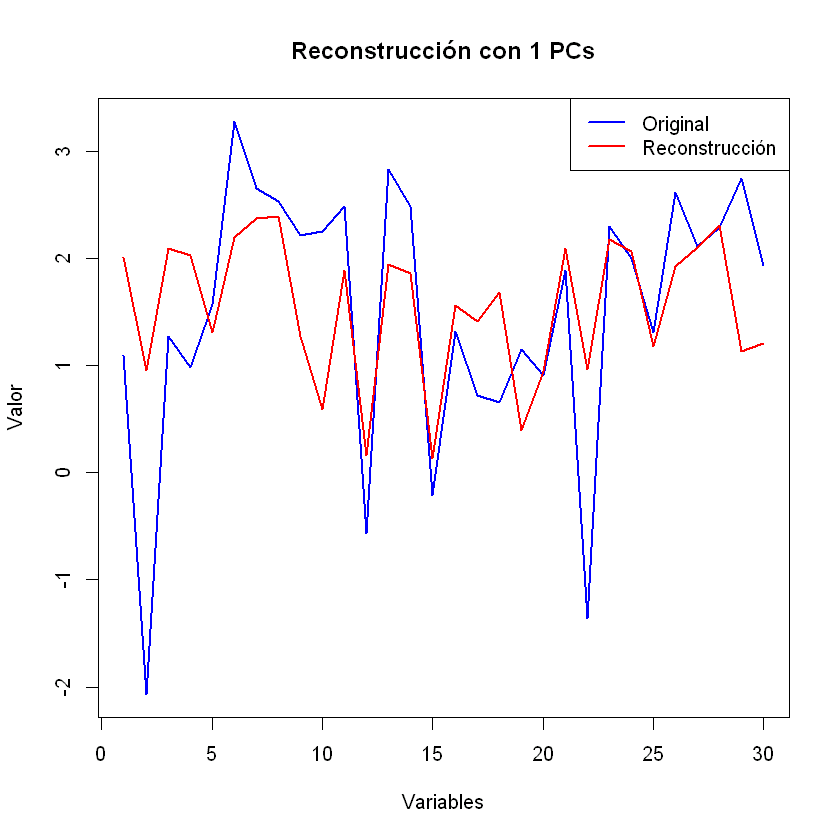

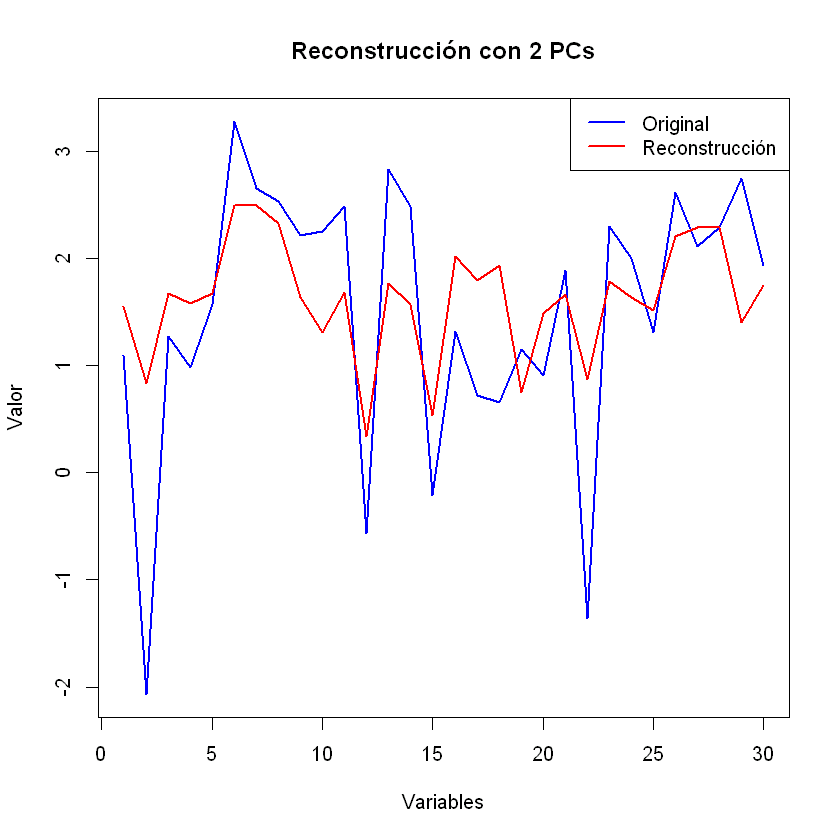

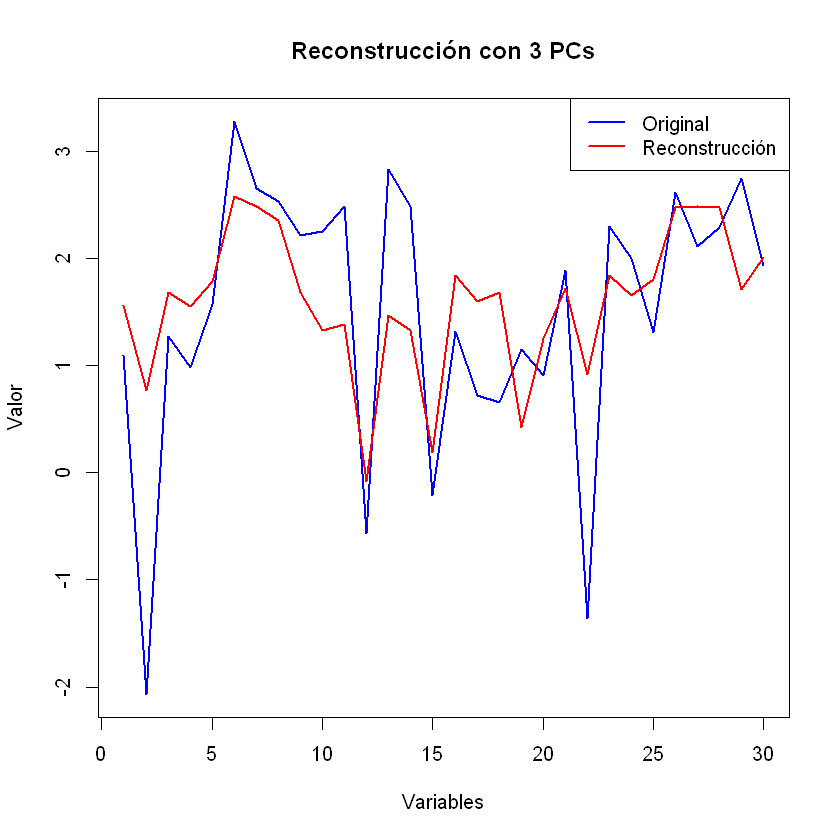

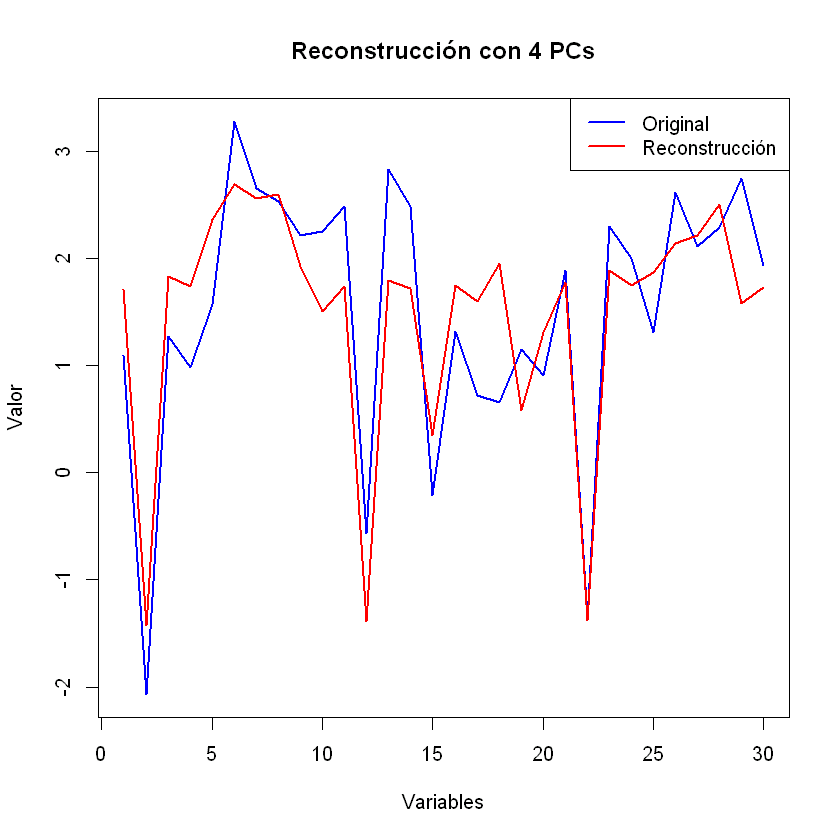

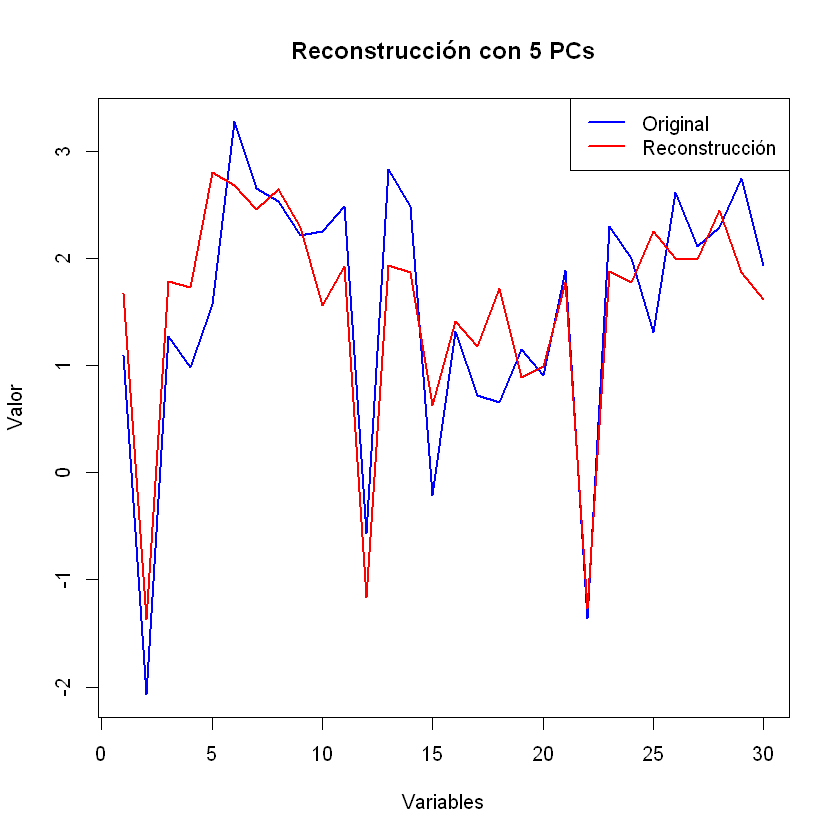

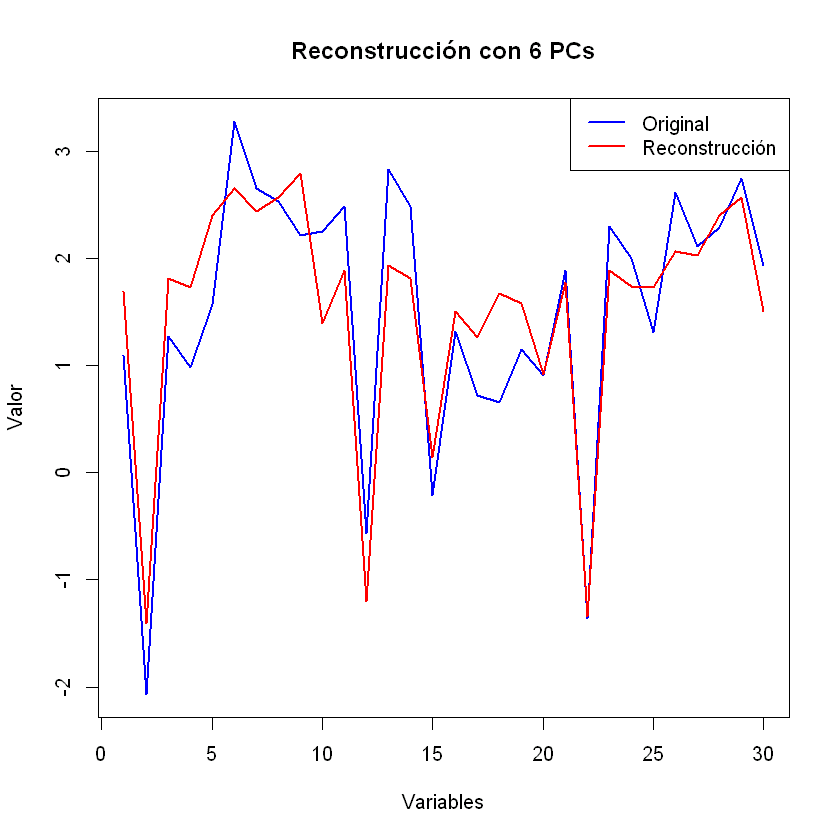

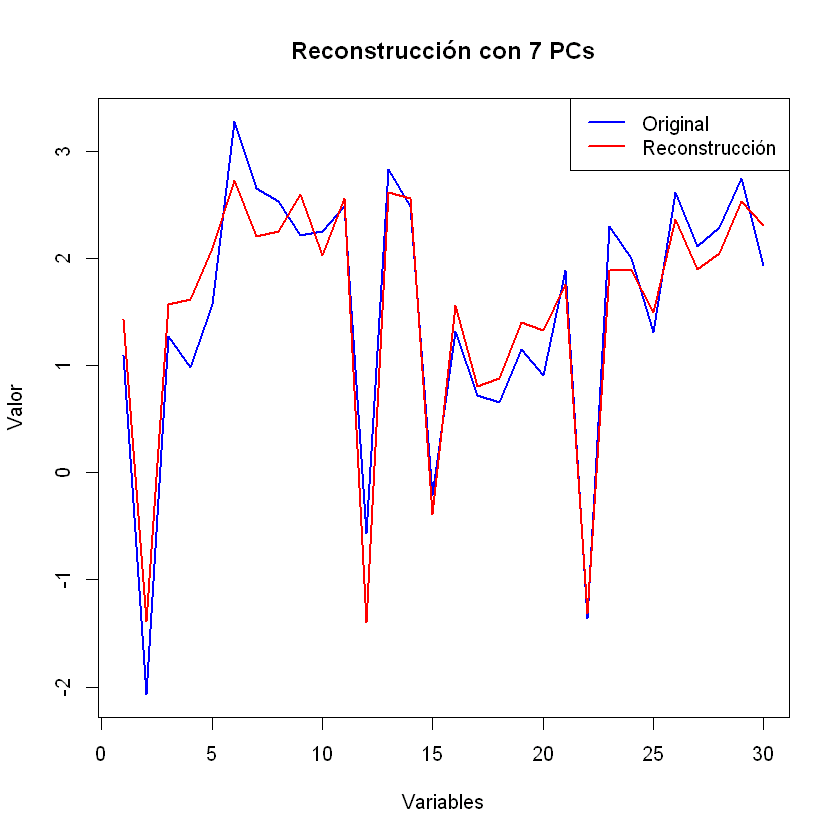

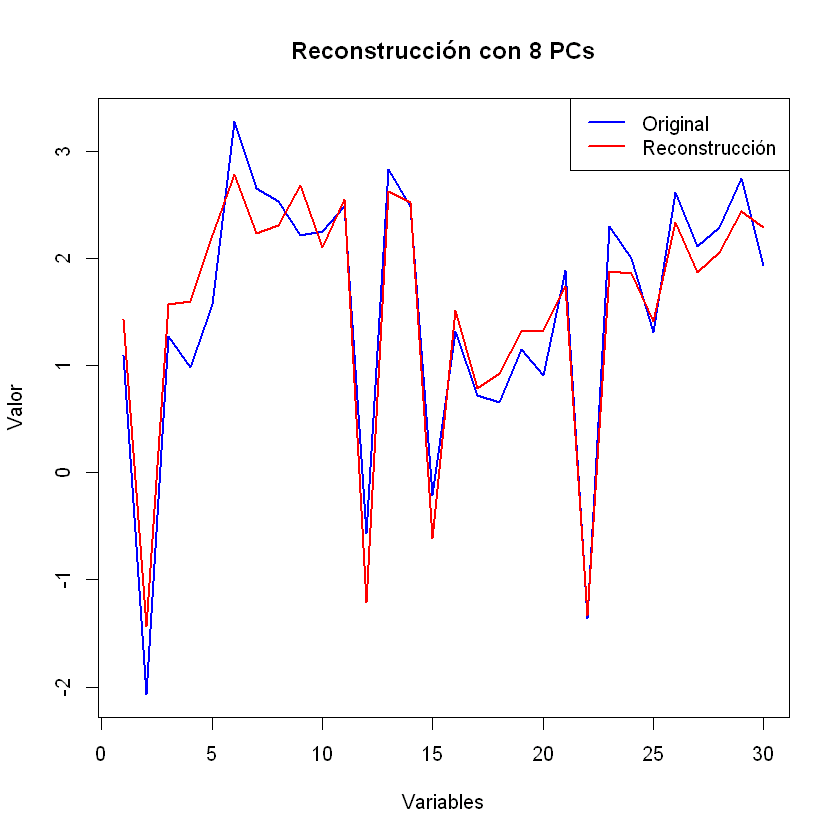

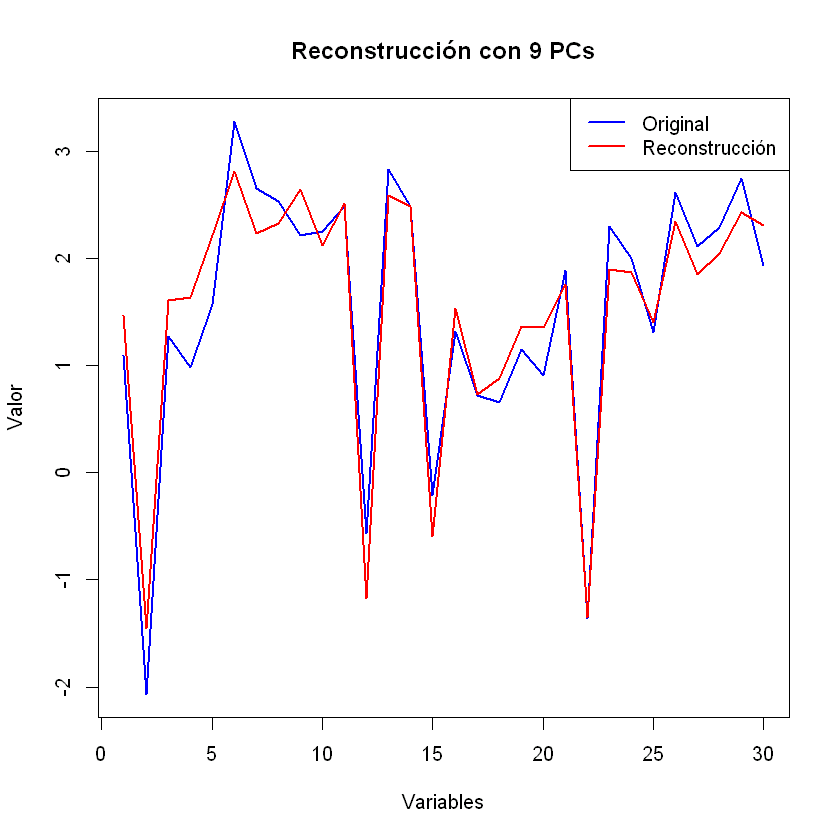

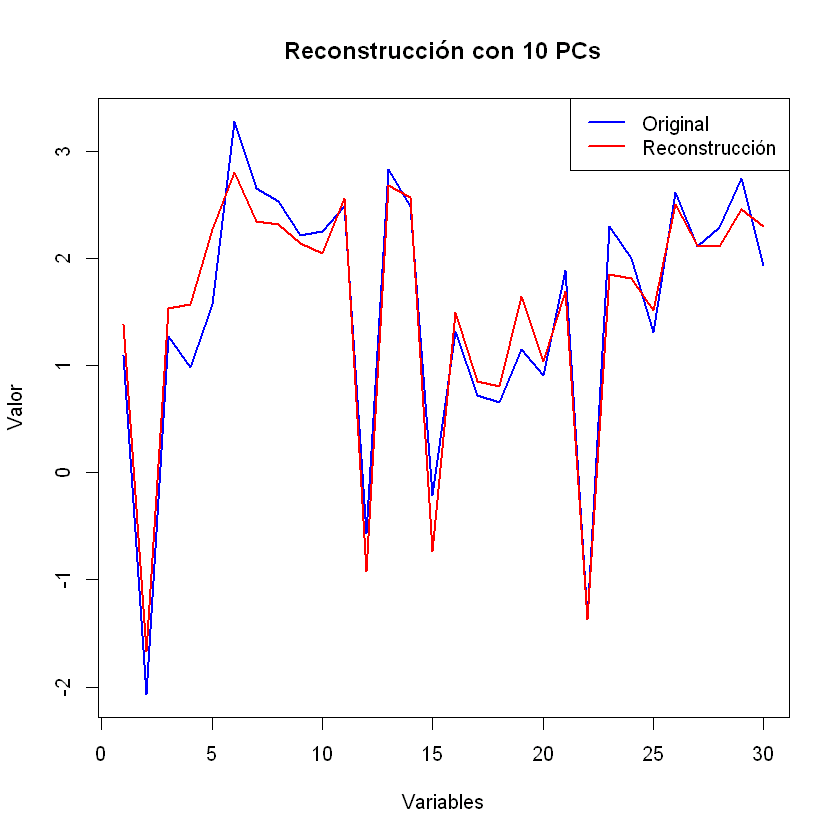

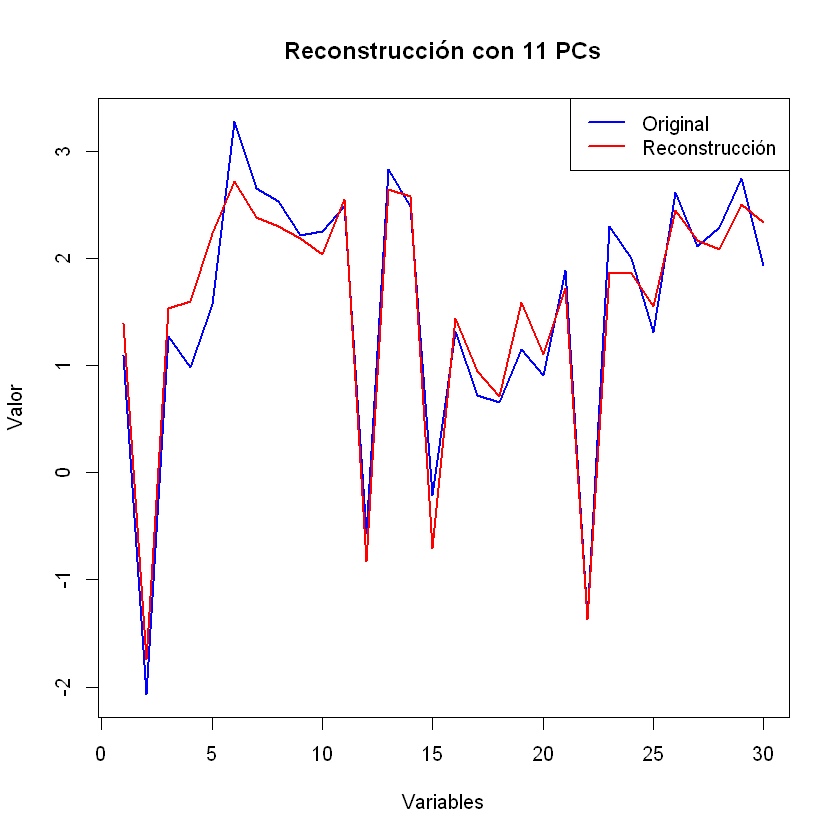

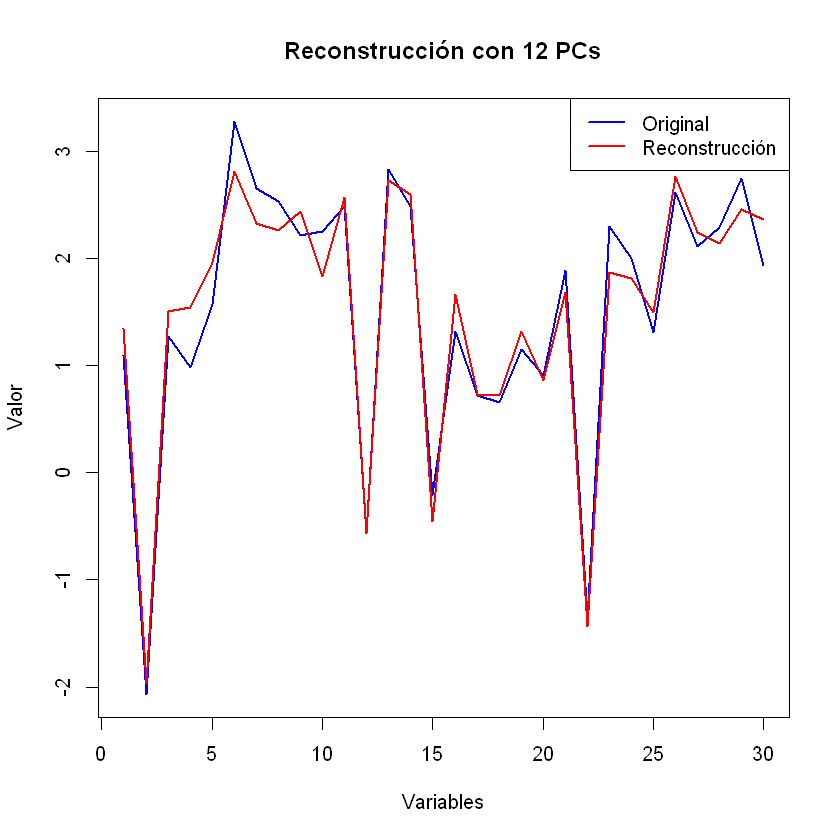

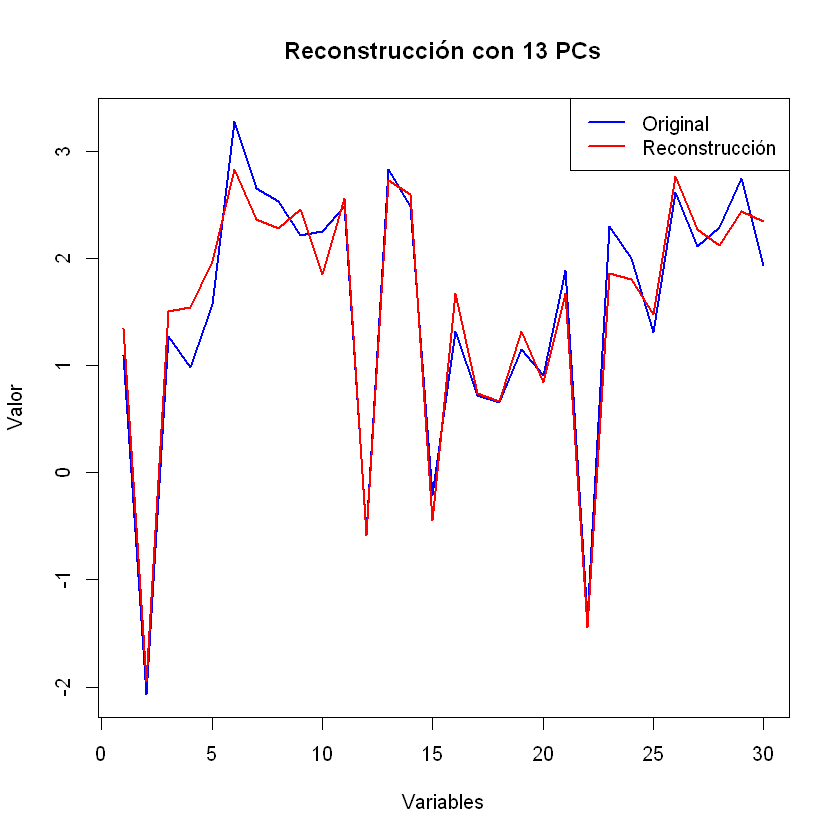

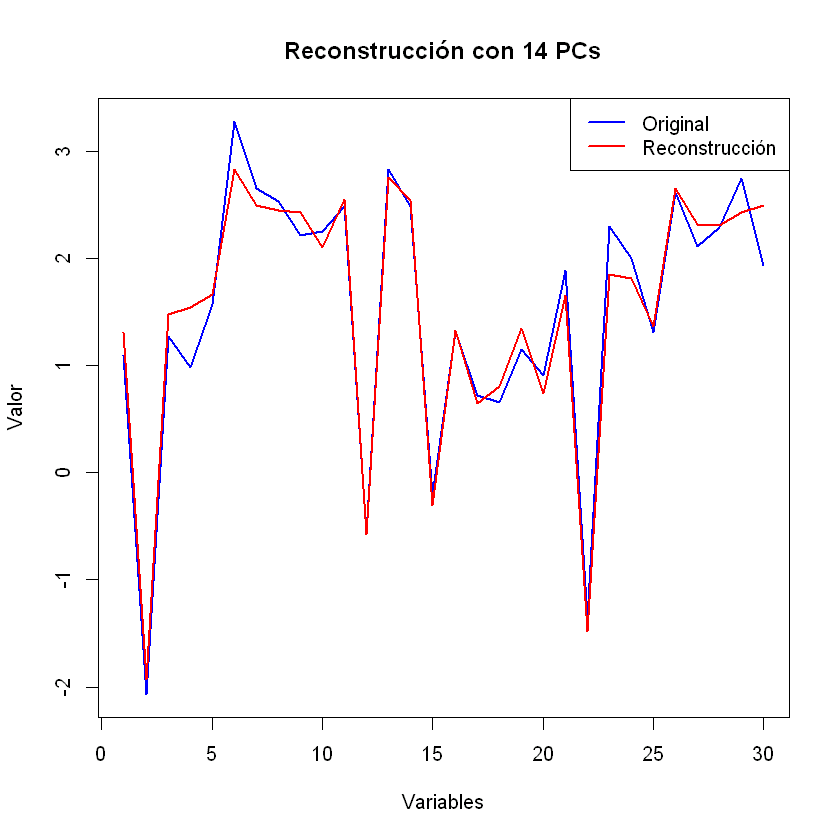

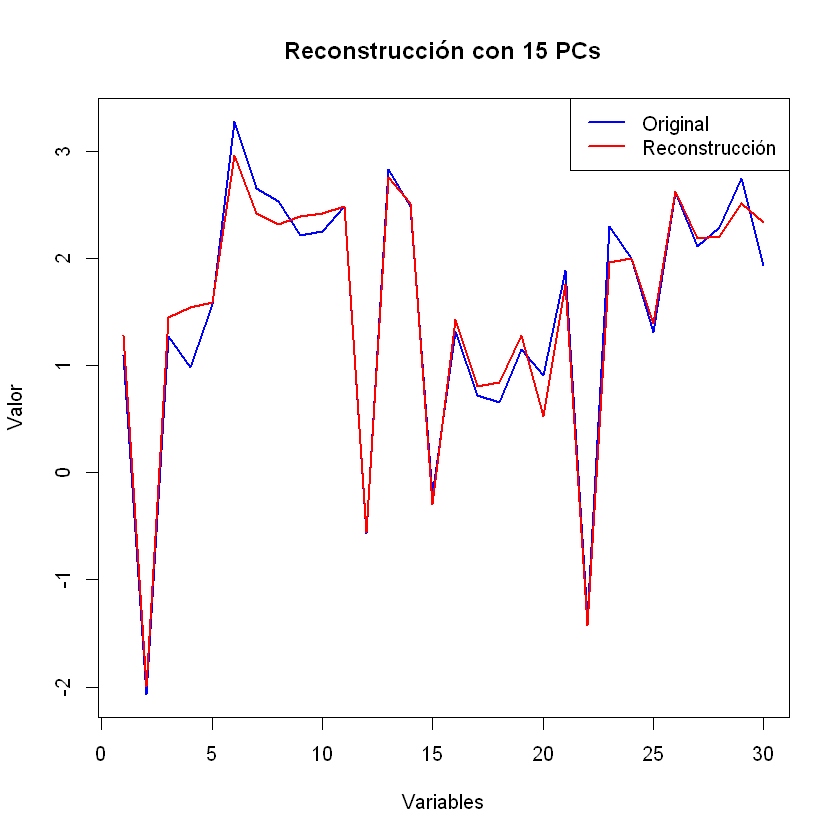

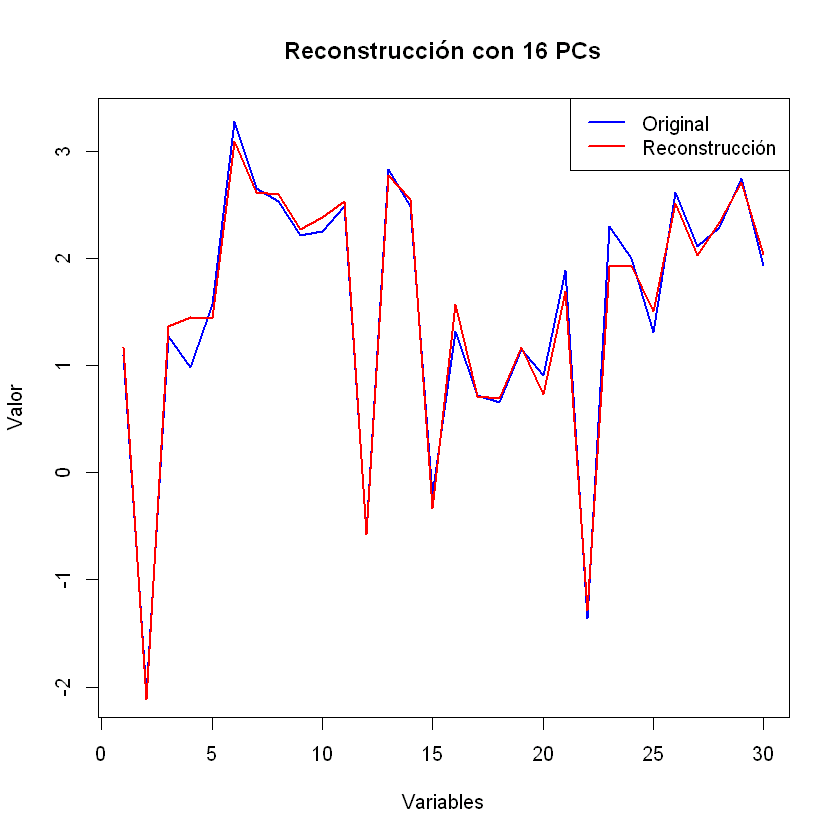

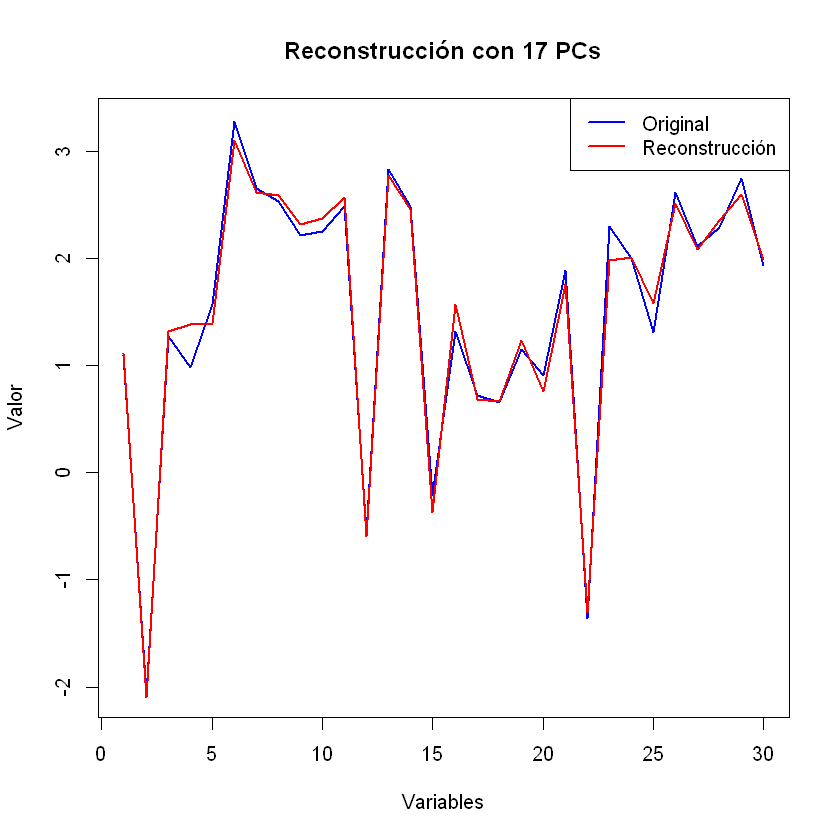

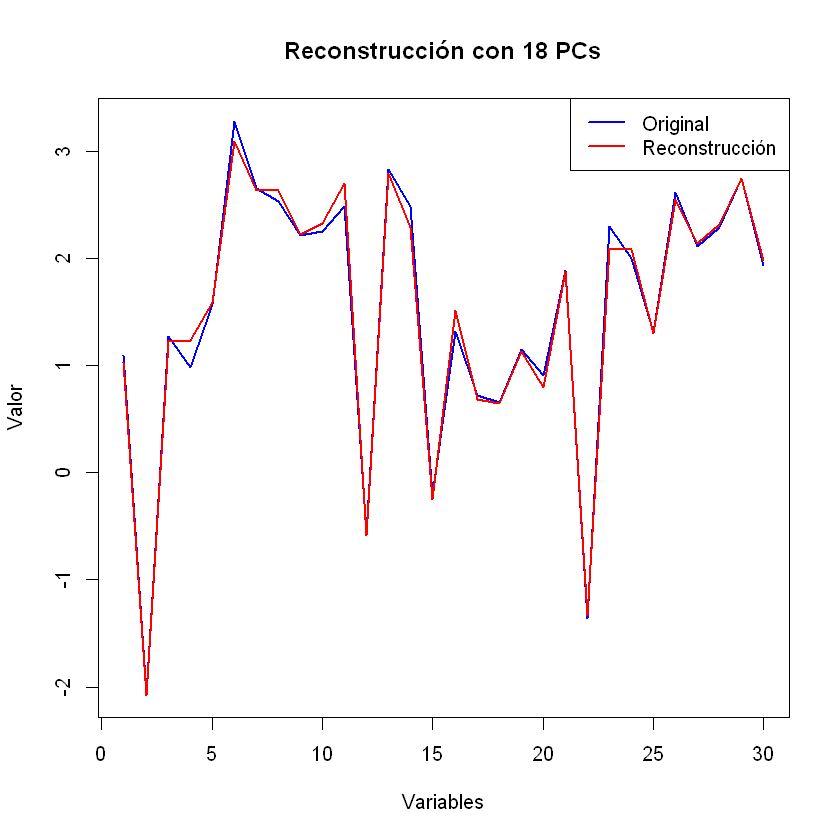

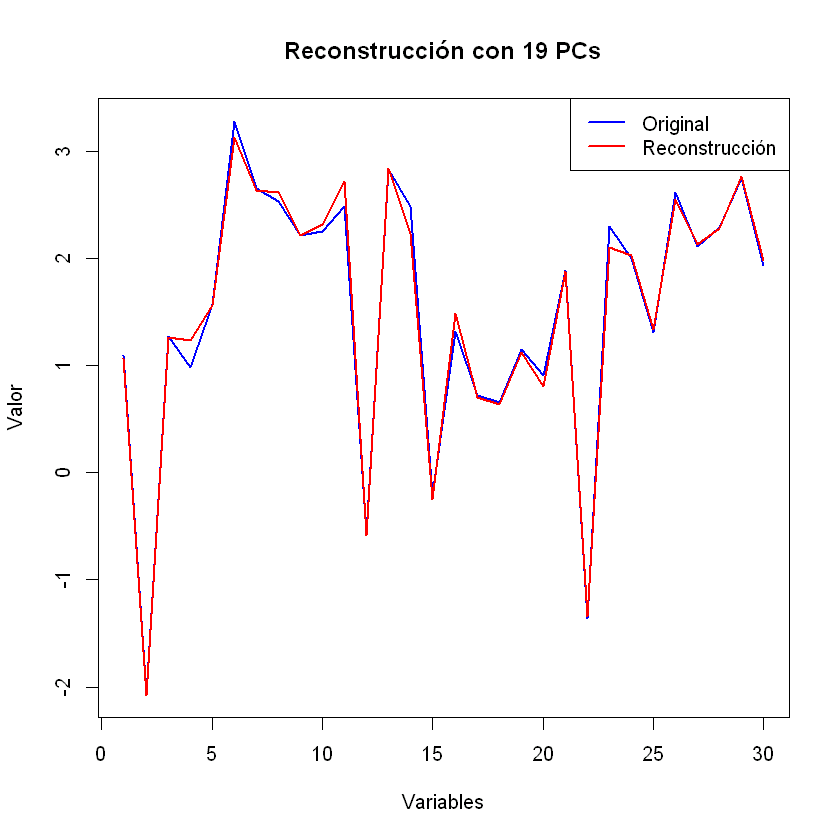

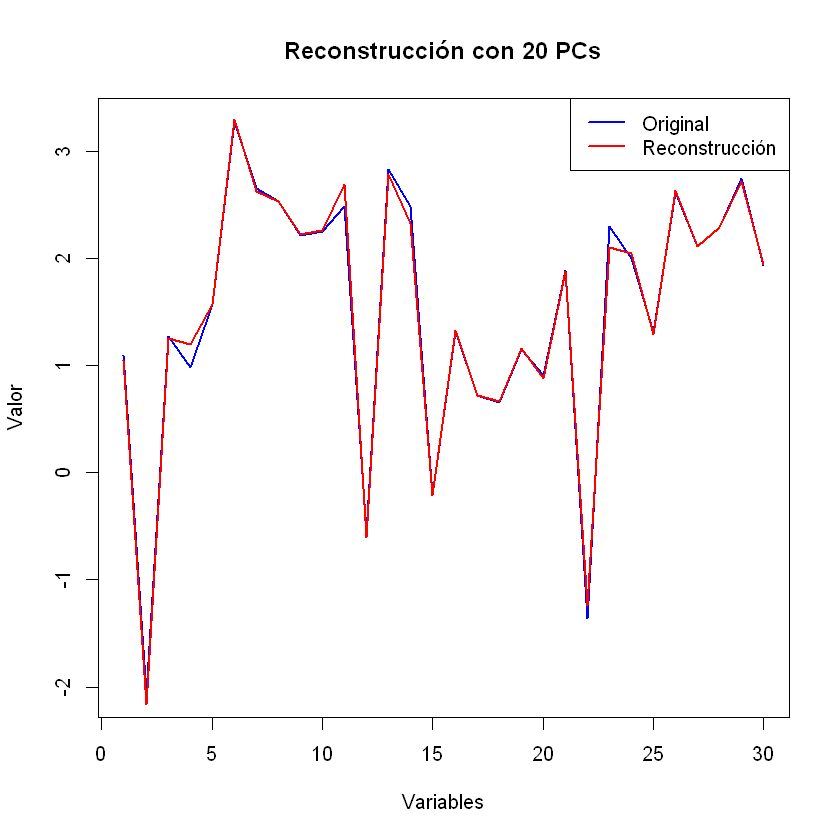

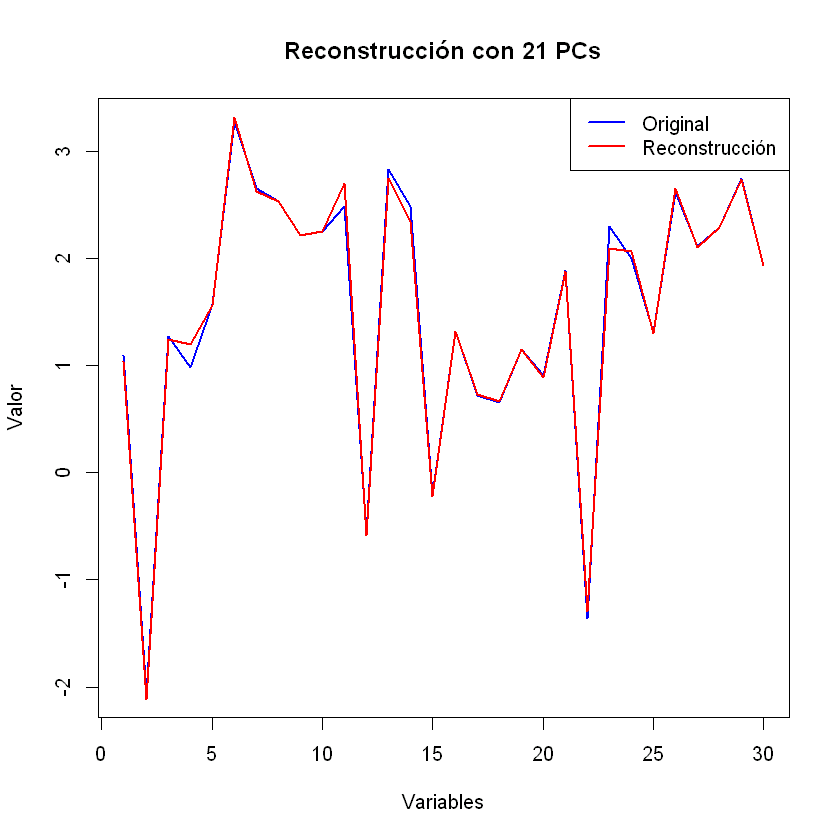

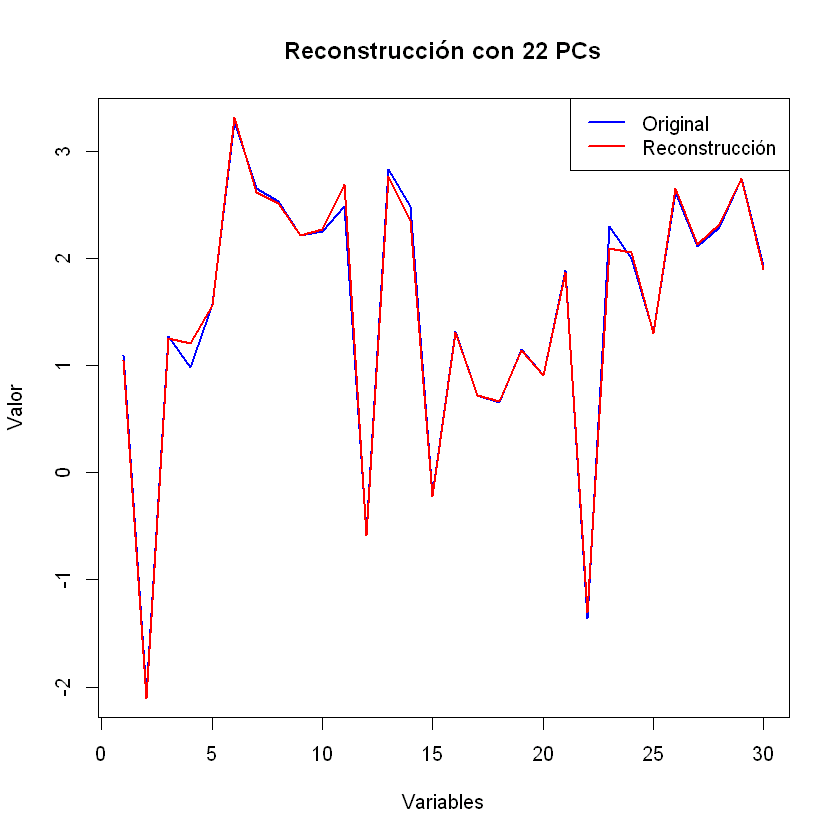

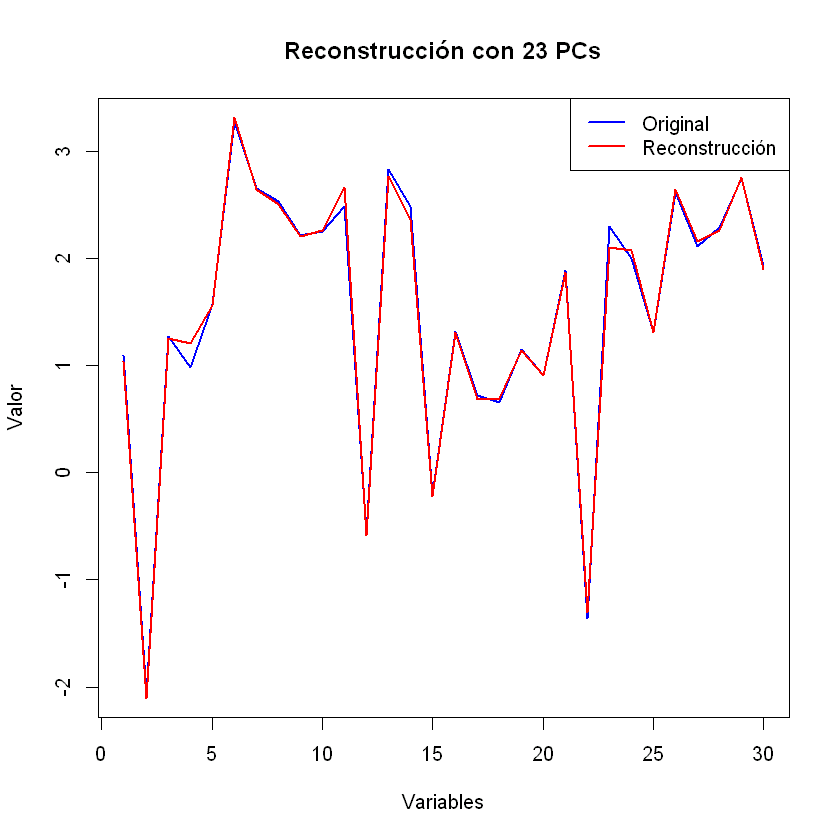

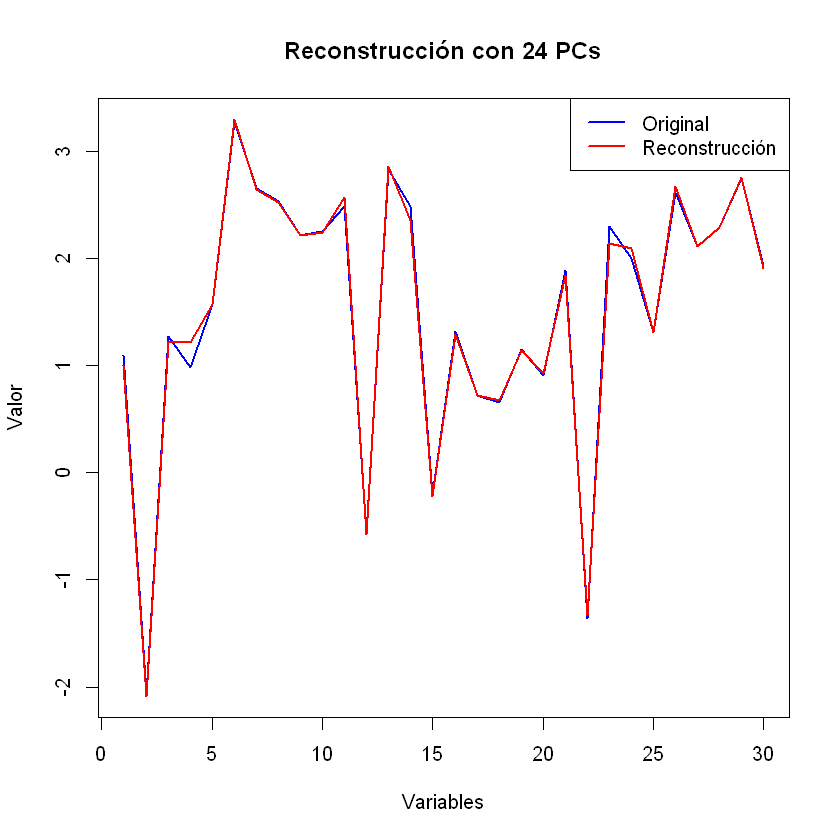

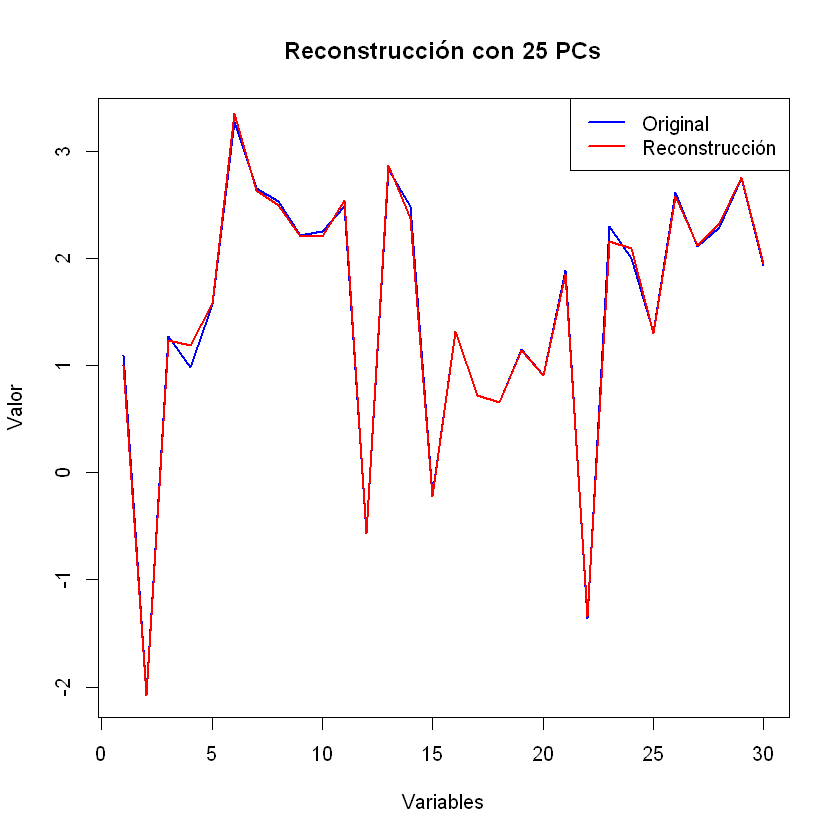

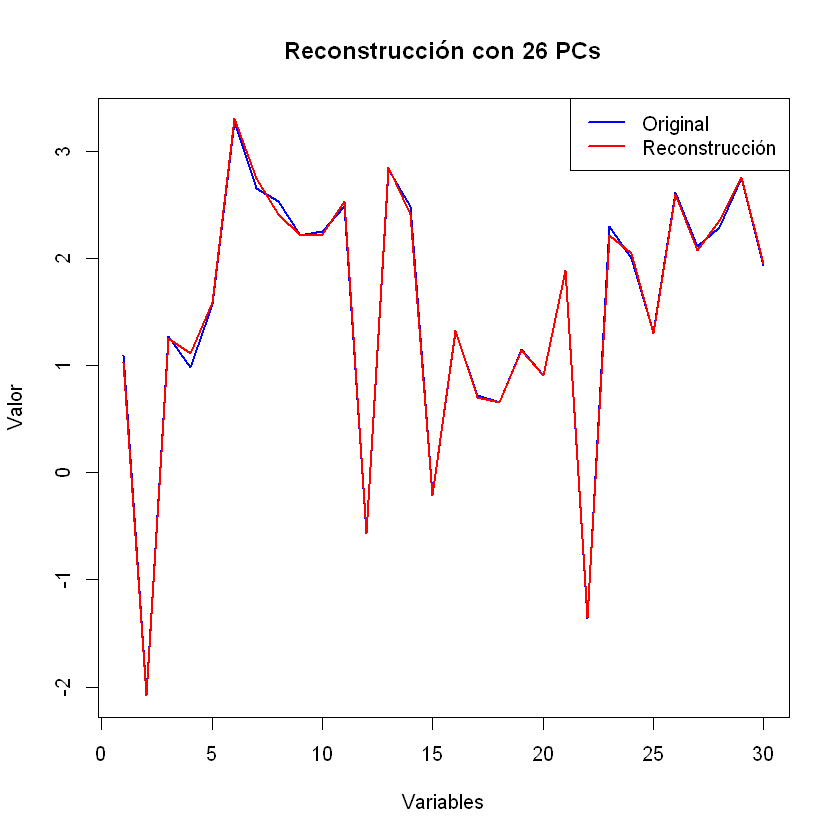

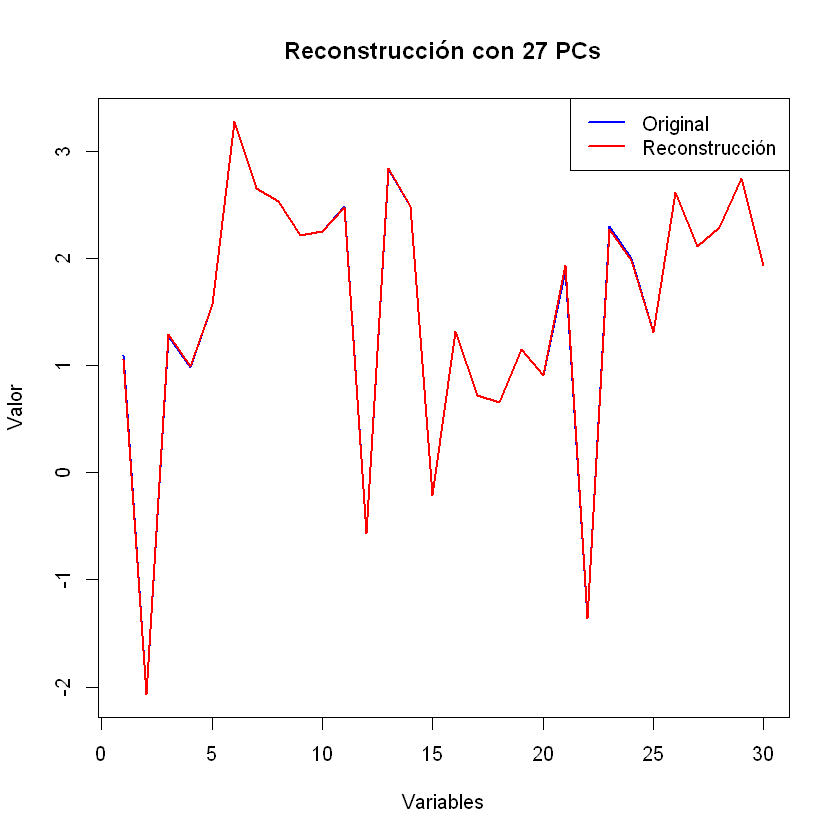

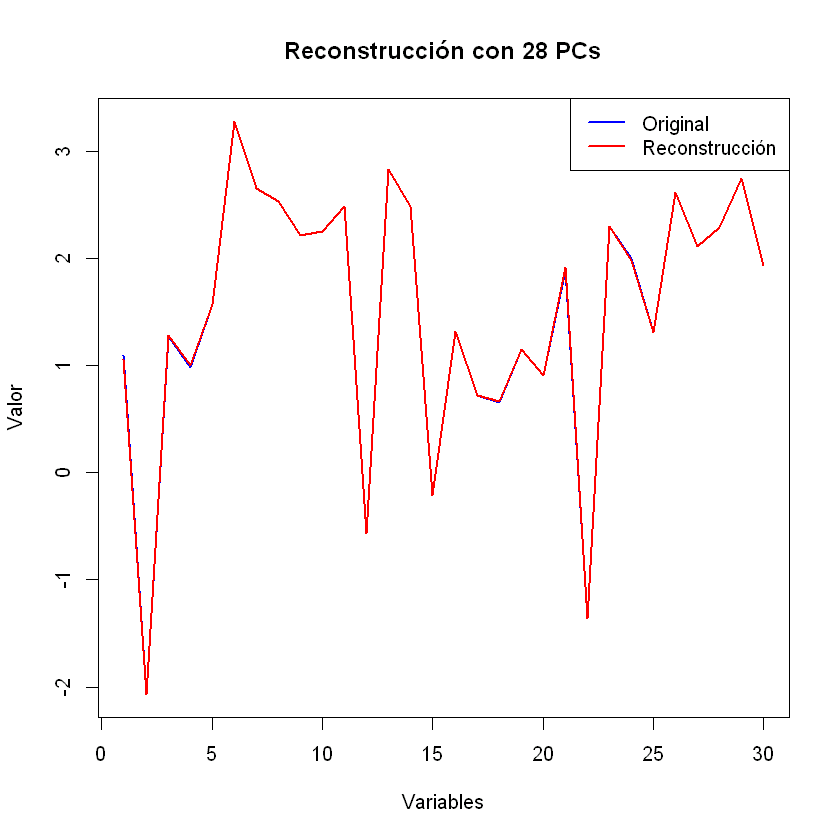

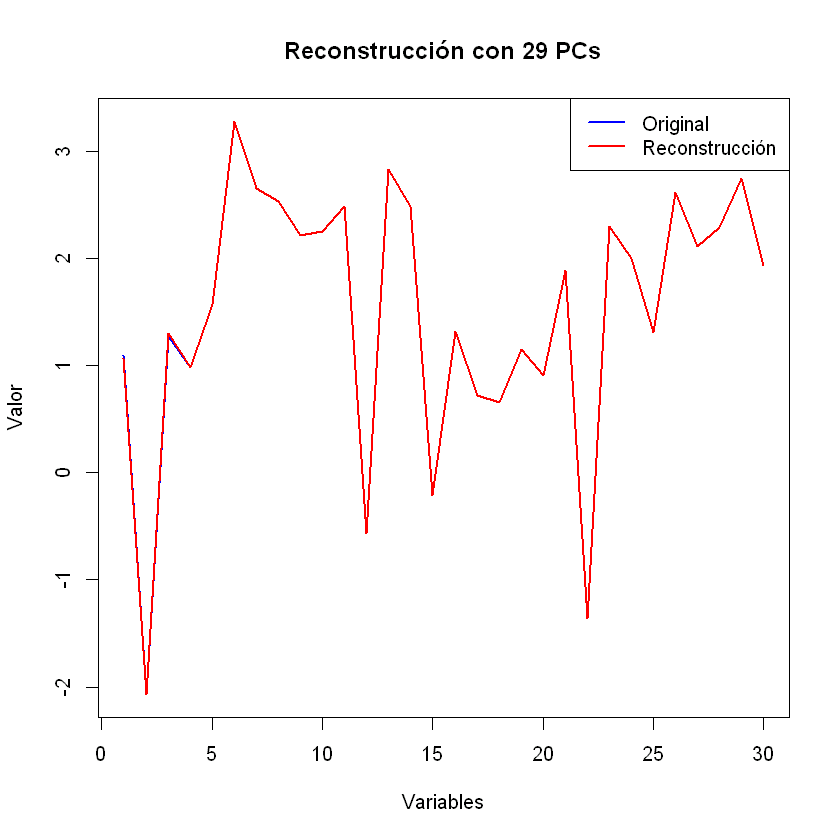

Se observa que a medida que se aumenta el número de componentes 
principales, la reconstruccion de la muestra se ajusta mejor a la original. 
Esto muestra que a mayor numero de componentes, se logra una mejor representacion
de los datos originales, representando la importancia del uso de componentes principales,
donde se logra reducir la dimensionalidad de los datos sin perder informacion.
Por ejemplo, se observa que en 10, la reconstruccion es muy similar a la original, 
es decir, que como se habia analizado anteriormente, 10 componentes podrian ser suficientes

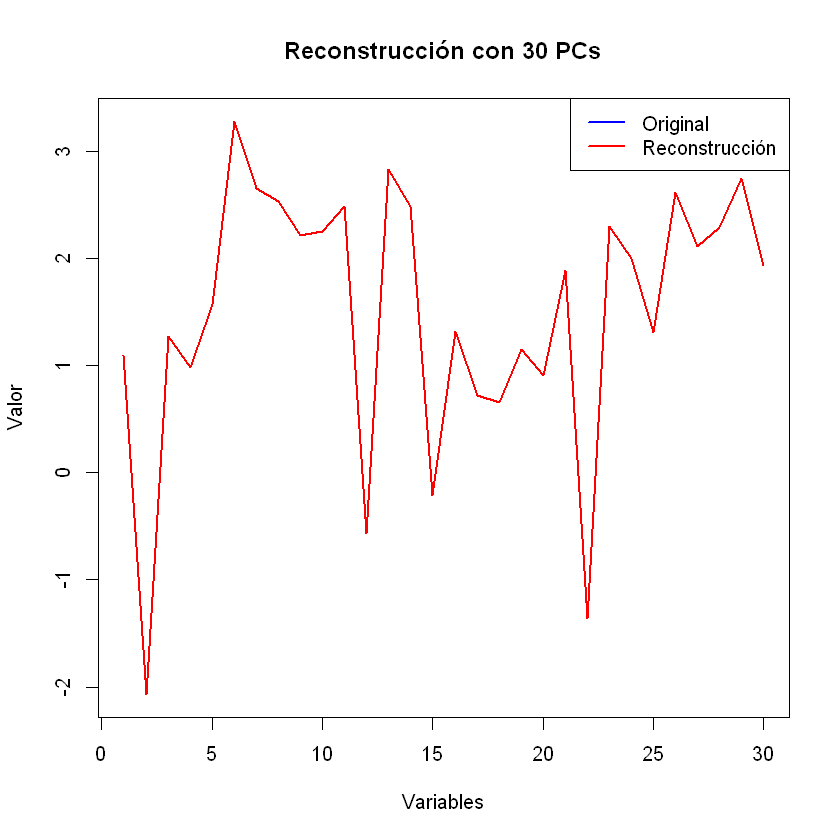

In [23]:
# 1.4.  Representa una de las muestras, junto con su reconstrucción mediante las r primeras PCs. 
#Comprueba el efecto de aumentar el valor de r, dando algunos valores de 1 a 30.

r = 1:30

for (i in r) {
  # Reconstrucción 
  reconstruccion = pca$x[1, 1:i] %*% t(pca$rotation[, 1:i])
  
  # Graficar la muestra original y su reconstrucción
  plot(1:ncol(df[, -1]), df[1, -1], type = "l", col = "blue", lwd = 2, xlab = "Variables", ylab = "Valor", main = paste("Reconstrucción con", i, "PCs"))
  lines(1:ncol(df[, -1]), reconstruccion[1, ], col = "red", lwd = 2)
  legend("topright", legend = c("Original", "Reconstrucción"), col = c("blue", "red"), lwd = 2)
}

cat("Se observa que a medida que se aumenta el número de componentes 
principales, la reconstruccion de la muestra se ajusta mejor a la original. 
Esto muestra que a mayor numero de componentes, se logra una mejor representacion
de los datos originales, representando la importancia del uso de componentes principales,
donde se logra reducir la dimensionalidad de los datos sin perder informacion.
Por ejemplo, se observa que en 10, la reconstruccion es muy similar a la original, 
es decir, que como se habia analizado anteriormente, 10 componentes podrian ser suficientes")

Cada barra en el grafico representa la importancia de cada variable
en la primera direccion discriminante. Es decir, que variables son mas importantes
para discriminar entre las dos clases de la variable respuesta. Por ejemplo,
se observa que la variable 21 resalta.

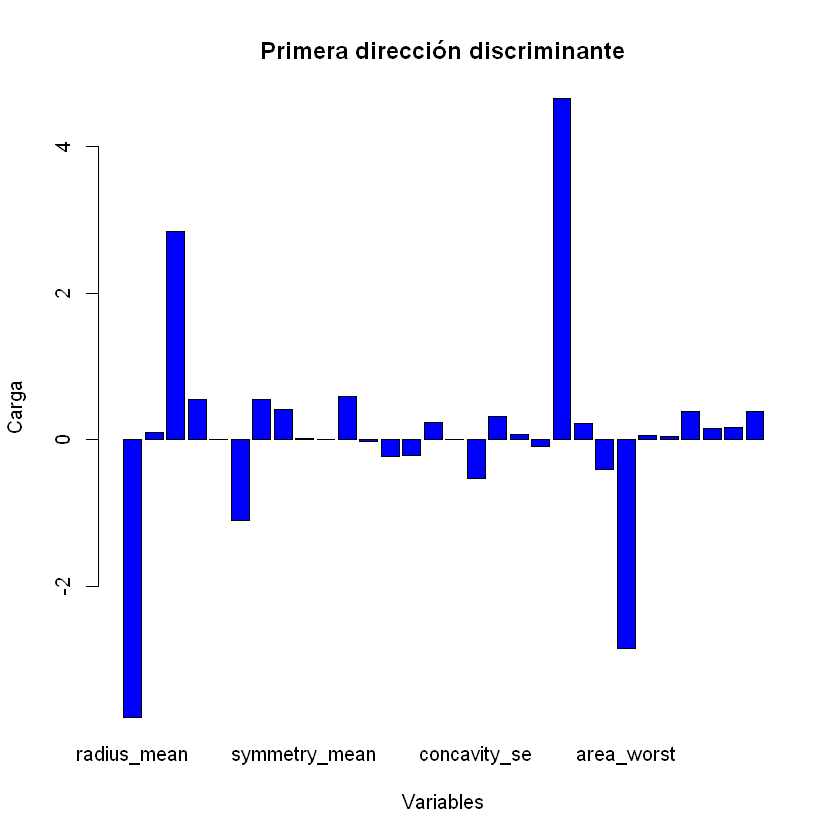

In [24]:
#2.1. Realiza un Análisis Discriminante Lineal sobre esta base de datos. 
#En este caso, se trata de una técnica de aprendizaje supervisado, en la que 
#involucramos la variable respuesta en la elección de direcciones de proyección 
#de los datos. Representa gráficamente la primera (y única, en este caso, 
#por tener solo dos clases) dirección discriminante (p.ej. usando `?barplot`).

lda = lda(diagnosis ~ ., data = df)

#lda$scaling contiene los coeficientes que definen las direcciones discriminantes.
barplot(lda$scaling[, 1], col = "blue", main = "Primera dirección discriminante", xlab = "Variables", ylab = "Carga")


cat("Cada barra en el grafico representa la importancia de cada variable
en la primera direccion discriminante. Es decir, que variables son mas importantes
para discriminar entre las dos clases de la variable respuesta. Por ejemplo,
se observa que la variable 21 resalta.") ## peso de cada variable predictora

#información de 30 variables predictoras estan en una sola dirección discriminante
#una sola direccion discrimiante porque son 2 clases, es direccion -1 el total de direcciones discriminantes
#si hay mas de 2 clases, se pueden tener mas direcciones discriminantes
# hay unas que se hacen 0 porque no aportan a la discriminación
#grafica muestra pesos de las variables predictoras en la dirección discriminante

Se observan dos histogramas que representan la distribucion de los datos
proyectados en la primera direccion discriminante, donde cada uno
corresponde a una de las clases de la variable respuesta. Ademas,
se observa que los datos estan bien separados, excaptuando
una pequeña superposicion en donde se podria tener problemas de 
clasificacion.

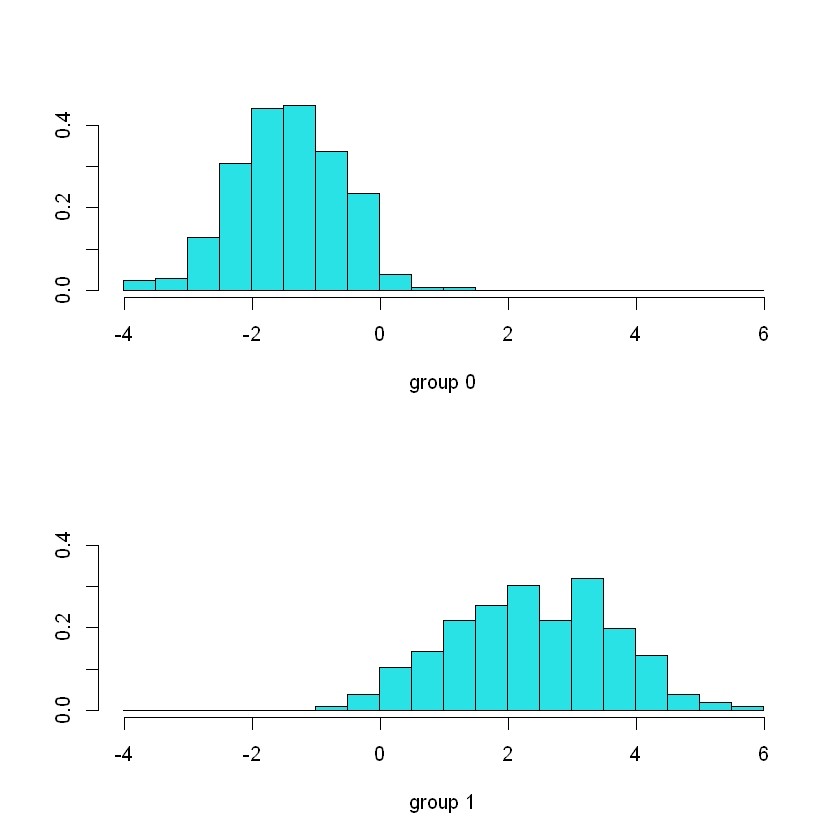

In [25]:
#  2.2. Utiliza LDA para predecir usando el conjunto de datos completo. 
#Examina los valores de la salida de la función (`?predict`, `?predict.lda`)
# y representa la distribución de los datos proyectados a lo largo de la 
#dirección dada por el primer LD (p.ej `?plot` o `?ldahist`).

prediccion = predict(lda, newdata = df)

# Representación de la distribución en LD1
ldahist(data = prediccion$x[, 1], g = df$diagnosis)

cat("Se observan dos histogramas que representan la distribucion de los datos
proyectados en la primera direccion discriminante, donde cada uno
corresponde a una de las clases de la variable respuesta. Ademas,
se observa que los datos estan bien separados, excaptuando
una pequeña superposicion en donde se podria tener problemas de 
clasificacion.") 


In [26]:
#  2.3. Obtén una tabla de contingencia para estudiar la
# pericia de este método lineal de clasificación.

confusionMatrix(prediccion$class, df$diagnosis)

cat("Se observa que el modelo tiene un accuracy de paroximadamente el 96%
en la clasificacion de los datos, lo cual es bastante bueno. Ademas, 
se observa una sensibilidad y especificidad alta, lo cual indica que el modelo
es bueno en la clasificacion de ambas clases. A su vez, esto se ve reflejado
en el bajo número de falsos positivos y falsos negativos.")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 355  18
         1   2 194
                                          
               Accuracy : 0.9649          
                 95% CI : (0.9462, 0.9784)
    No Information Rate : 0.6274          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9236          
                                          
 Mcnemar's Test P-Value : 0.0007962       
                                          
            Sensitivity : 0.9944          
            Specificity : 0.9151          
         Pos Pred Value : 0.9517          
         Neg Pred Value : 0.9898          
             Prevalence : 0.6274          
         Detection Rate : 0.6239          
   Detection Prevalence : 0.6555          
      Balanced Accuracy : 0.9547          
                                          
       'Positive' Class : 0               
                              

Se observa que el modelo tiene un accuracy de paroximadamente el 96%
en la clasificacion de los datos, lo cual es bastante bueno. Ademas, 
se observa una sensibilidad y especificidad alta, lo cual indica que el modelo
es bueno en la clasificacion de ambas clases. A su vez, esto se ve reflejado
en el bajo número de falsos positivos y falsos negativos.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9965

En la curva ROC se observa que el modelo tiene un alto poder de 
discriminacion, ya que la curva se encuentra muy cerca del punto (0,1).
Ademas, se observa que el valor de AUC es aproximadamente 0.99, lo cual
es bastante bueno, indicando que el modelo clasifica bien los datos
y es casi perfecto.

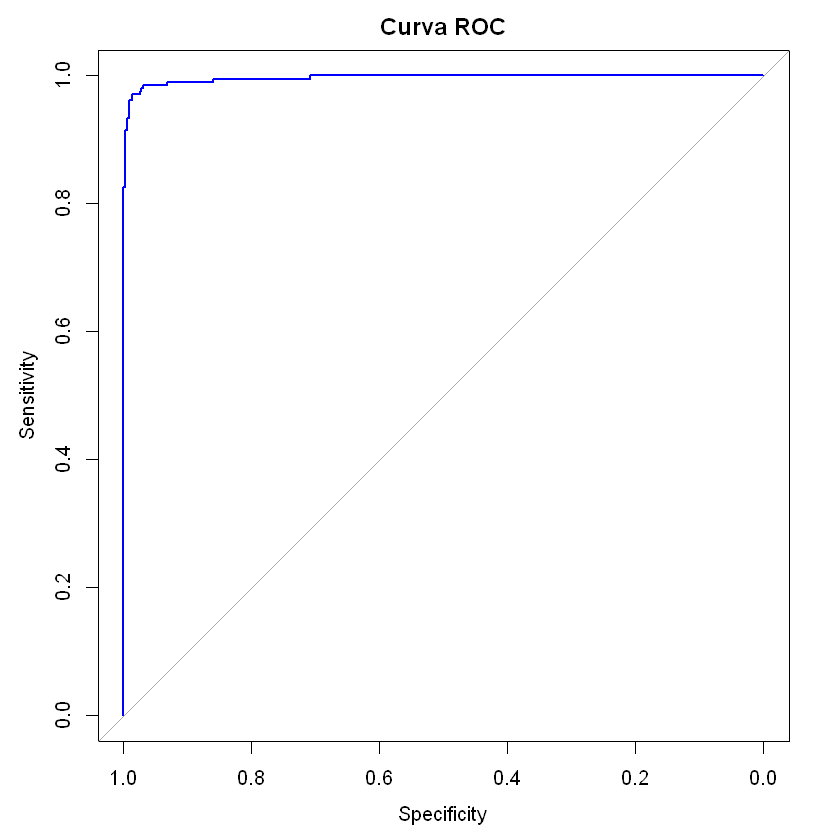

In [27]:
#  2.4. El LDA proporciona una predicción probabilista de las clases, 
#ya que esta técnica implementa un clasificador bayesiano, basado en 
#las probabilidades a posteriori de pertenencia a cada clase, bajo la 
#hipótesis de normalidad. Utilizar una técnica de validación probabilista,
# como la curva ROC para evaluar la pericia de esta predicción probabilista.

roc = roc(df$diagnosis, prediccion$posterior[, 2])

plot(roc, col = "blue", main = "Curva ROC")

auc(roc)

cat("En la curva ROC se observa que el modelo tiene un alto poder de 
discriminacion, ya que la curva se encuentra muy cerca del punto (0,1).
Ademas, se observa que el valor de AUC es aproximadamente 0.99, lo cual
es bastante bueno, indicando que el modelo clasifica bien los datos
y es casi perfecto.") 



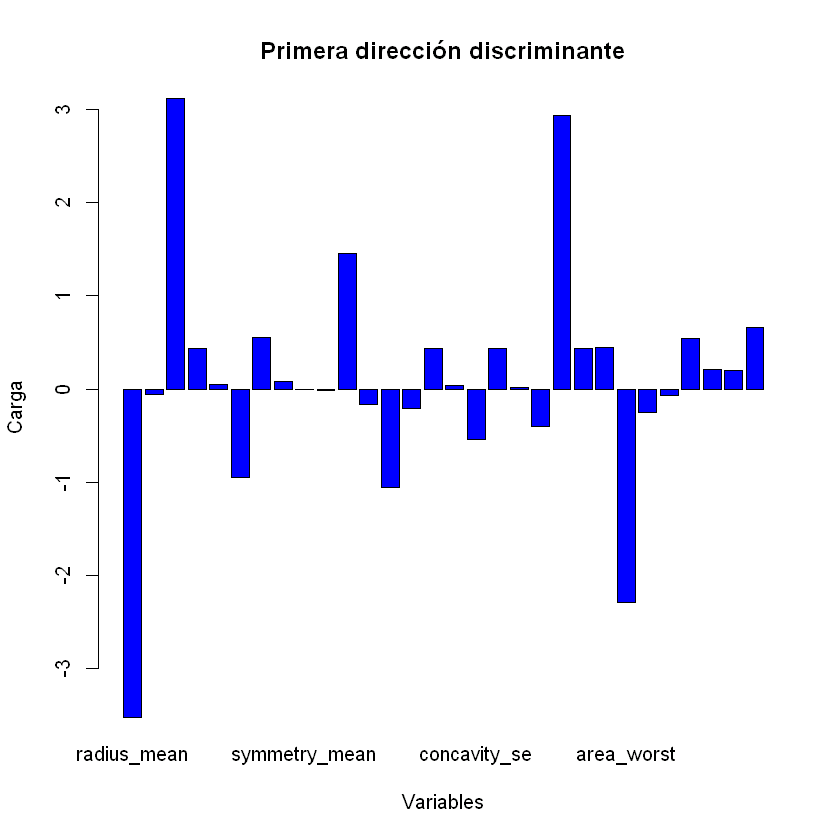

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 106   5
         1   1  58
                                          
               Accuracy : 0.9647          
                 95% CI : (0.9248, 0.9869)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9233          
                                          
 Mcnemar's Test P-Value : 0.2207          
                                          
            Sensitivity : 0.9907          
            Specificity : 0.9206          
         Pos Pred Value : 0.9550          
         Neg Pred Value : 0.9831          
             Prevalence : 0.6294          
         Detection Rate : 0.6235          
   Detection Prevalence : 0.6529          
      Balanced Accuracy : 0.9556          
                                          
       'Positive' Class : 0               
                              

Setting levels: control = 0, case = 1

Setting direction: controls < cases



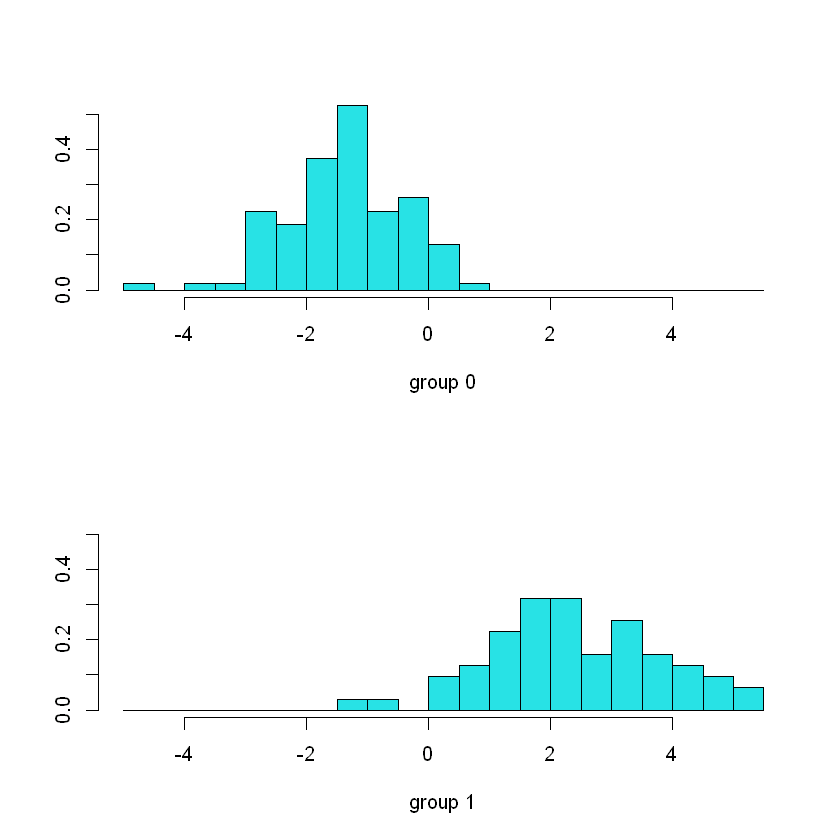

Area under the curve: 0.988

 Con los resultados obtenidos se puede observar la capacidad de generalizacion
de la téctica, donde se observa que el modelo tiene un accuracy de aproximadamente
el 96% para test, bastante cercano al obtenido cuando se hizo con todo el dataset.
Ademas, se observa que el valor de AUC es aproximadamente 0.98, lo cual
es muy bueno. Tambien se observa un comportamiento similar en la proyeccion de los datos
en la primera direccion discriminante, donde se observa una buena separacion de las clases.
Finalmente, en los histogramas se observa una superposicion de los datos, lo cual
es similar a lo observado en el modelo anterior.

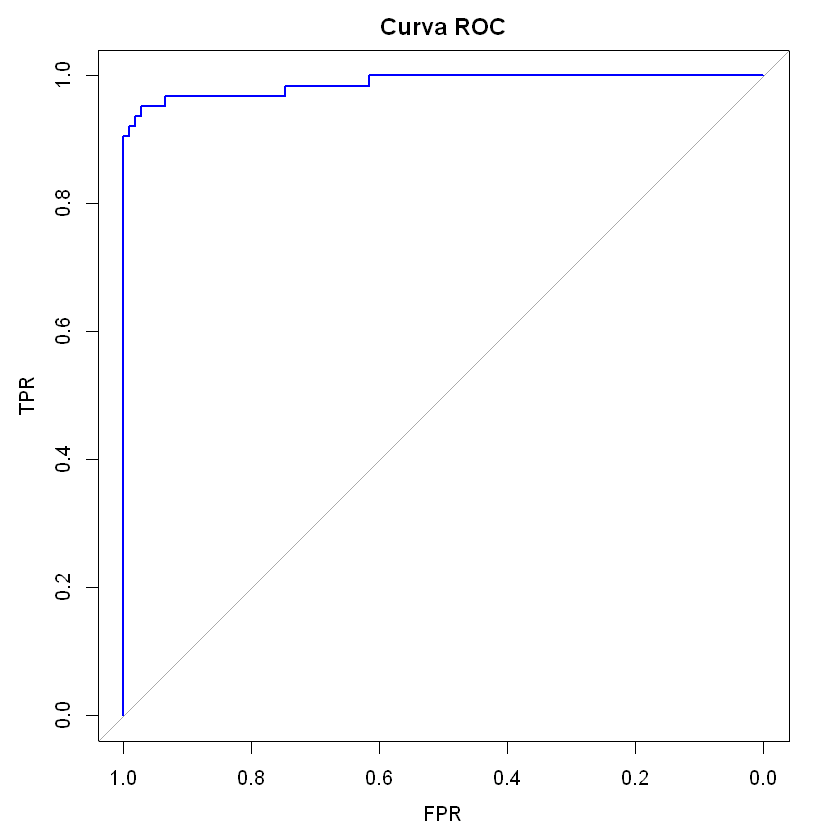

In [28]:
#  2.5. Repetir lo anterior pero mediante una validación cruzada tipo 
#*hold out*, para ver la capacidad de generalización de esta técnica lineal.

set.seed(123)
particiones = createDataPartition(df$diagnosis, p = 0.7, list = FALSE)
train = df[particiones, ]
test = df[-particiones, ]

#Apliquemos LDA a los datos de entrenamiento
lda_2 = lda(diagnosis ~ ., data = train)
barplot(lda_2$scaling[, 1], col = "blue", main = "Primera dirección discriminante", xlab = "Variables", ylab = "Carga")

#Predicción - proyección de los datos en la primera dirección discriminante
prediccion_2 = predict(lda_2, newdata = test)
ldahist(data = prediccion_2$x[, 1], g = test$diagnosis)
confusionMatrix(prediccion_2$class, test$diagnosis)

#curva ROC
roc_2 = roc(test$diagnosis, prediccion_2$posterior[, 2])
#grafica
plot(roc_2, col = "blue", main = "Curva ROC", xlab = "FPR", ylab = "TPR")
auc(roc_2)

cat(" Con los resultados obtenidos se puede observar la capacidad de generalizacion
de la téctica, donde se observa que el modelo tiene un accuracy de aproximadamente
el 96% para test, bastante cercano al obtenido cuando se hizo con todo el dataset.
Ademas, se observa que el valor de AUC es aproximadamente 0.98, lo cual
es muy bueno. Tambien se observa un comportamiento similar en la proyeccion de los datos
en la primera direccion discriminante, donde se observa una buena separacion de las clases.
Finalmente, en los histogramas se observa una superposicion de los datos, lo cual
es similar a lo observado en el modelo anterior.")
